**Lab2-DL: B4-EKG-arytmi-CNN.ipynb** (ELMED219) | Prioritet: 1 (kjerne)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arvidl/ELMED219-2026/blob/main/Lab2-DL/notebooks/B4-EKG-arytmi-CNN.ipynb)

# 🫀 B4: EKG Arytmi-Klassifikasjon med Nevrale Nettverk

**Praktisk Implementering av CNN for Medisinsk Signalanalyse**

---

## 🎯 Læringsmål

I denne notebooken skal vi:
- **Forstå** EKG-signaler og MIT-BIH Arrhythmia Database
- **Implementere** CNN for 1D signal-klassifikasjon
- **Trene** modell på reelle medisinske data
- **Evaluere** og tolke resultater i klinisk kontekst
- **Reflektere** over etiske og praktiske aspekter

## 📋 Innhold

1. **EKG-signaler og arytmier** - Medisinsk bakgrunn
2. **MIT-BIH Database** - Datasett og annotasjoner
3. **Data-håndtering** - Nedlasting og preprosessering
4. **CNN-arkitektur** - Design for EKG-klassifikasjon
5. **Trening og optimalisering** - Praktisk implementering
6. **Evaluering** - Metrikker og klinisk tolkning
7. **Refleksjoner** - Etikk og videre arbeid

---

## 🏥 Klinisk Relevans

**For Medisinere:**
- Akuttmedisin: Rask deteksjon av livstruende arytmier
- Kardiologi: Tidlig oppdagelse av hjerte-kar-sykdommer
- Anestesi: Overvåking av hjertefunksjon under operasjoner

**For Psykologer:**
- Hjerte-rate variabilitet (HRV) og stressrespons
- Psykosomatisk medisin og mental helse

**For Sykepleiere:**
- Kontinuerlig EKG-overvåking på sykehus
- Triage og pasientvurdering


In [1]:
# Importer nødvendige biblioteker
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from matplotlib.patches import Circle, FancyBboxPatch
import warnings
import time
import os
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from scipy.signal import butter, filtfilt
import platform
import subprocess
import sys

warnings.filterwarnings('ignore')

# Sett opp plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🫀 Klar for EKG arytmi-klassifikasjon!")
print(f"PyTorch versjon: {torch.__version__}")
print(f"CUDA tilgjengelig: {torch.cuda.is_available()}")
print(f"MPS tilgjengelig: {torch.backends.mps.is_available()}")


🫀 Klar for EKG arytmi-klassifikasjon!
PyTorch versjon: 2.5.1+cu121
CUDA tilgjengelig: True
MPS tilgjengelig: False


## 1. EKG-signaler og Arytmier

### 🫀 Hvorfor EKG som Eksempel på Nevrale Nettverk i Medisin?

**Direkte Sammenheng med Aksjonspotensialer:**
EKG (elektrokardiografi) er den perfekte broen mellom biologiske aksjonspotensialer og kunstige nevroner. Hjertets elektriske aktivitet er direkte relatert til aksjonspotensialene vi studerte tidligere:

- **Hjertemuskelceller** bruker samme ionekanaler som nerveceller
- **Natrium-, kalium- og kalsium-ioner** skaper hjertets elektriske signaler
- **Depolarisering og repolarisering** skjer på samme måte som i nerveceller
- **EKG-målinger** registrerer disse elektriske signalene fra kroppens overflate

**Fra Biologi til AI:**
- **Biologisk**: Aksjonspotensialer i hjertemuskelceller
- **Måling**: EKG-registrering av elektriske signaler
- **AI**: Nevrale nettverk som analyserer EKG-mønstre
- **Klinisk**: Automatisk deteksjon av arytmier og hjerteinfarkt

### 🏥 Klinisk Relevans for Helsepersonell

**For Medisinere:**
- **Akuttmedisin**: Rask deteksjon av livstruende arytmier
- **Kardiologi**: Tidlig oppdagelse av hjerte-kar-sykdommer
- **Anestesi**: Overvåking av hjertefunksjon under operasjoner
- **Intensivmedisin**: Kontinuerlig overvåking av kritiske pasienter

**For Psykologer:**
- **Hjerte-rate variabilitet (HRV)**: Variasjonen i tidsintervaller mellom hjertebank
  - *Definisjon*: HRV er et mål på autonomt nervesystems funksjon og stressrespons
  - *Klinisk betydning*: Lav HRV assosieres med stress, angst, depresjon og økt risiko for hjerte-kar-sykdommer
  - *Behandling*: HRV-biofeedback brukes i behandling av angst og stresslidelser
- **Psykosomatisk medisin**: Sammenheng mellom mental helse og hjertefunksjon
- **Stressforskning**: Objektiv måling av stressrespons

**For Sykepleiere:**
- **Overvåking**: Kontinuerlig EKG-overvåking på sykehus
- **Triage**: Rask vurdering av pasienter med brystsmerter
- **Rehabilitering**: Overvåking under hjerterehabilitering
- **Hjemmepleie**: Remote monitoring av kroniske pasienter


## 2. MIT-BIH Arrhythmia Database

### 📊 MIT-BIH Arrhythmia Database: En Gyllen Standard

**Hva er MIT-BIH Arrhythmia Database?**
- **Opprettet**: 1980-1990 av Massachusetts Institute of Technology og Beth Israel Hospital
- **Innhold**: 48 to-kanals EKG-opptak, hver 30 minutter lang
- **Sampling rate**: 360 Hz (360 målinger per sekund)
- **Annotasjoner**: Eksperter har markert hver hjerteslag med diagnose
- **Åpen tilgang**: Fritt tilgjengelig for forskning og utdanning

**Hvorfor er denne databasen så viktig?**
- **Gyllen standard**: Brukes som referanse for alle EKG-algoritmer
- **Klinisk validert**: Annotasjoner fra eksperter
- **Reproduserbarhet**: Standardisert format og kvalitet
- **Forskning**: Grunnlag for tusenvis av vitenskapelige artikler

### 🔢 Record-nummering og Struktur

**Record-numrene** i MIT-BIH Arrhythmia Database representerer:

##### **100-124**: **Første gruppe (25 records)**
- **Valgt tilfeldig** fra 4000 24-timers EKG-opptak
- **Blandet populasjon**: 60% innleggelser, 40% poliklinikk
- **Representerer** typiske EKG-mønstre i generell populasjon

##### **200-234**: **Andre gruppe (25 records)**
- **Valgt selektivt** for å inkludere sjeldne, men klinisk viktige arytmier
- **Inneholder** spesifikke arytmi-typer som ikke ville være godt representert i tilfeldig utvalg
- **Eksempler**: Ventrikulær takykardi, atrieflimmer, komplekse arytmier

### 📁 Filtyper og Format

##### **`.hea` fil (Header file)**
- **Innhold**: Metadata for EKG-record
- **Eksempel innhold**:
  ```
  Record: 100
  Number of signals: 2
  Sampling frequency: 360 Hz
  Number of samples: 650000
  Signal 1: MLII (modified lead II)
  Signal 2: V5
  ```
- **Brukes til**: Beskriver hvordan EKG-signalet skal leses

##### **`.dat` fil (Data file)**
- **Innhold**: De faktiske EKG-signaldataene
- **Format**: Binær format med 11-bit oppløsning
- **Innhold**: 
  - To kanaler (MLII og V5)
  - 360 samples per sekund
  - 30 minutter data (650,000 samples)
  - Amplitude-verdier i millivolt (mV)
- **Brukes til**: Den faktiske EKG-målingen

##### **`.atr` fil (Annotation file)**
- **Innhold**: Annotasjoner og markeringer av hjerteslag
- **Format**: Binær format med annotasjonsdata
- **Innhold**:
  - **R-peak posisjoner**: Når hvert hjerteslag skjer
  - **Arytmi-klassifisering**: Hvilken type hjerteslag (N, L, R, A, V)
  - **Tidsstempel**: Nøyaktig tidspunkt for hver annotasjon
- **Brukes til**: Automatisk deteksjon og klassifisering av arytmier

### 🏷️ Arytmi-klassifikasjon

**5 hovedklasser vi skal klassifisere:**

| Symbol | Navn | Norsk | Beskrivelse |
|--------|------|-------|-------------|
| **N** | Normal Beat | Normalt hjerteslag | Normal sinusrytme |
| **L** | Left Bundle Branch Block | Venstre grenblokk | Blokkering i venstre gren |
| **R** | Right Bundle Branch Block | Høyre grenblokk | Blokkering i høyre gren |
| **A** | Atrial Premature Beat | Atrielt prematurt slag | Tidlige slag fra forkammer |
| **V** | Premature Ventricular Contraction | Prematurt ventrikulært slag | Tidlige slag fra hovedkammer |


## 3. Data-håndtering og Nedlasting

### EKG data  (PhysioNet: MIT-BIH Arrhytmia Database)

https://github.com/MIT-LCP/wfdb-python

https://physionet.org/content/mitdb/1.0.0/

https://physionet.org/content/mitdb/get-zip/1.0.0/  (mit-bih-arrhythmia-database-1.0.0.zip)


### 📥 Nedlasting av MIT-BIH Database

Vi bruker `wfdb` (Waveform Database) biblioteket for å laste ned og håndtere EKG-data fra PhysioNet.

In [2]:
# Sjekk om wfdb er tilgjengelig
try:
    import wfdb
    WFDB_AVAILABLE = True
    print("✅ wfdb er installert og tilgjengelig")
except ImportError:
    WFDB_AVAILABLE = False
    print("⚠️ wfdb er ikke installert. Installer med: pip install wfdb")
    print("Vil bruke simulerte data i stedet...")

import os
import numpy as np
import matplotlib.pyplot as plt

✅ wfdb er installert og tilgjengelig


In [3]:
%%time
# Last ned EKG-data fra PhysioNet
def download_physionet_data_fixed():
    """
    Laster ned EKG-data direkte fra PhysioNet 
    """
    try:
        import wfdb
        
        data_dir = "./data/ecg"
        os.makedirs(data_dir, exist_ok=True)
        
        print("📥 Laster ned EKG-data fra PhysioNet...")
        
        # Last ned hele MIT-BIH databasen med dl_database
        try:
            wfdb.dl_database('mitdb', data_dir)
            print("✅ MIT-BIH database lastet ned")
            
            # Sjekk om vi har lastet ned noen filer
            downloaded_files = [f for f in os.listdir(data_dir) if f.endswith('.hea')]
            if downloaded_files:
                print(f"✅ Totalt {len(downloaded_files)} EKG-records lastet ned")
                return True
            else:
                print("❌ Ingen filer ble lastet ned")
                return False
                
        except Exception as e:
            print(f"⚠️ Kunne ikke laste ned database: {e}")
            return False
            
    except ImportError:
        print("⚠️ wfdb ikke tilgjengelig, prøver alternativ nedlasting...")
        print('⚠️ Bruker simulerte data i stedet...')
        return False

# Test den fikse funksjonen
print("🔧 Testing fixed download function...")
if WFDB_AVAILABLE:
    success = download_physionet_data_fixed()
else:
    print('⚠️ Bruker simulerte data i stedet...')
    success = False

if not success:
    print("💡 Bruker simulerte data i stedet...")

🔧 Testing fixed download function...
📥 Laster ned EKG-data fra PhysioNet...
Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 

*Visualisering av EKG-signaler fra hver av klassene:*

- **Normal sinusrytme (N)**: Normal hjerterytme
- **Left bundle branch block (L)**: Blokkering i venstre gren
- **Right bundle branch block (R)**: Blokkering i høyre gren  
- **Atrial premature (A)**: Tidlige slag fra forkammer
- **Premature ventricular contractions (V)**: Tidlige slag fra hovedkammer

kfr. den offisielle MIT-BIH Arrhythmia Database annotasjonen fra [PhysioNet](https://physionet.org/content/mitdb/1.0.0)

🫀 Kjører EKG-visualisering...
📊 Fant 48 EKG-filer
🔍 Søker gjennom alle filer for å finne arytmi-typer...
  📁 121: A, N, V
  📁 200: A, N, V
  📁 117: A, N
  📁 113: N
  📁 104: N, V
  📁 103: A, N
  📁 210: N, V
  📁 220: A, N
  📁 213: A, N, V
  📁 209: A, N, V
  📁 207: A, L, R, V
  📁 114: A, N, V
  📁 219: A, N, V
  📁 232: A, R
  📁 105: N, V
  📁 208: N, V
  📁 212: N, R
  📁 118: A, R, V
  📁 111: L, V
  📁 214: L, V
  📁 108: A, N, V
  📁 123: N, V
  📁 119: N, V
  📁 230: N, V
  📁 101: A, N
  📁 107: V
  📁 231: A, N, R, V
  📁 234: N, V
  📁 116: A, N, V
  📁 124: A, R, V
  📁 109: L, V
  📁 203: N, V
  📁 102: N, V
  📁 122: N
  📁 115: N
  📁 233: A, N, V
  📁 106: N, V
  📁 215: A, N, V
  📁 100: A, N, V
  📁 202: A, N, V
  📁 217: N, V
  📁 201: A, N, V
  📁 112: A, N
  📁 228: A, N, V
  📁 205: A, N, V
  📁 222: A, N
  📁 223: A, N, V
  📁 221: N, V

📈 Statistikk per arytmi-klasse:
  N: 74992 eksempler fra 40 filer
    Filer: 121, 121, 121, 121, 121...
  L: 8070 eksempler fra 4 filer
    Filer: 207, 207, 207, 207, 2

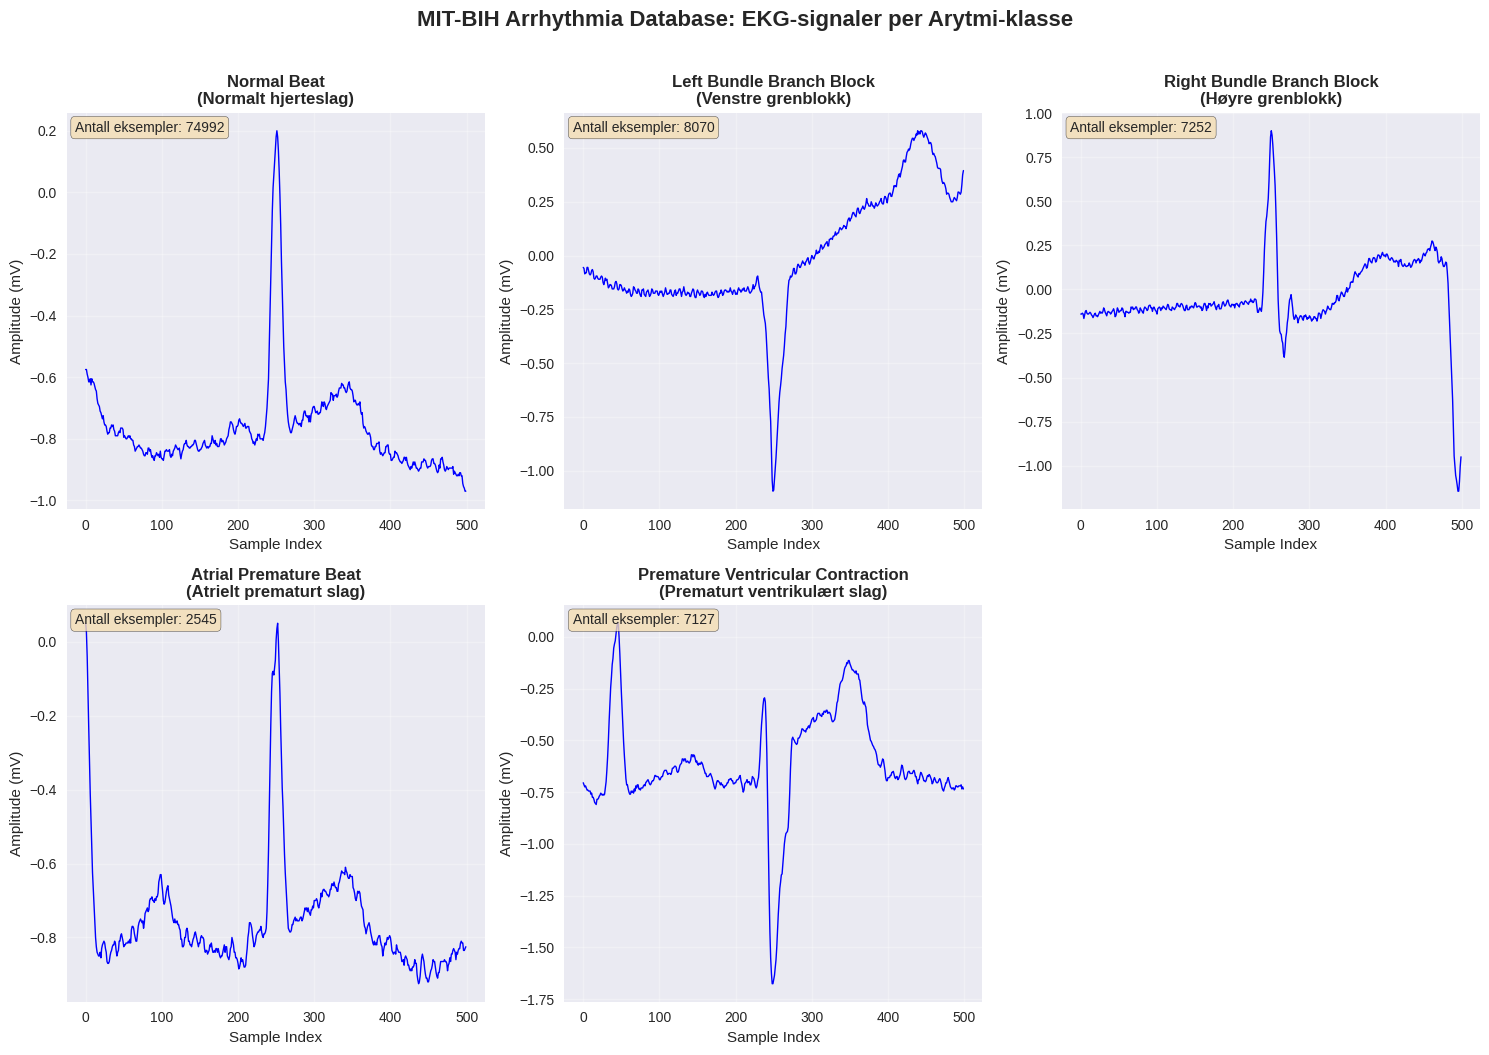


✅ EKG visualisering fullført!


In [5]:
# EKG-visualisering som finner alle arytmi-typer
def visualize_ecg_by_rhythm_type():
    """
    Visualiserer EKG-signaler fra hver av de 5 arytmi-klassene i MIT-BIH databasen
    Sjekker flere filer for å finne alle typer
    """
    import wfdb
    import os
    import matplotlib.pyplot as plt
    import numpy as np
    from collections import defaultdict
    
    # Definer arytmi-typer (offisielle MIT-BIH annotasjoner)
    arrhythmia_types = {
        'N': 0,  # Normal beat
        'L': 1,  # Left bundle branch block beat
        'R': 2,  # Right bundle branch block beat
        'A': 3,  # Atrial premature beat
        'V': 4   # Premature ventricular contraction
    }
    
    # Mappet til data
    data_dir = "./data/ecg"
    
    # Finn alle .hea filerpip install lime
    hea_files = [f for f in os.listdir(data_dir) if f.endswith('.hea')]
    print(f"📊 Fant {len(hea_files)} EKG-filer")
    
    # Samle data per arytmi-type
    rhythm_data = defaultdict(list)
    file_stats = defaultdict(list)  # Hold styr på hvilke filer som inneholder hver type
    
    # Gå gjennom alle filer for å finne alle arytmi-typer
    print("🔍 Søker gjennom alle filer for å finne arytmi-typer...")
    
    for hea_file in hea_files:  # Sjekk alle filer
        try:
            record_name = hea_file.replace('.hea', '')
            record_path = os.path.join(data_dir, record_name)
            
            # Last inn EKG-signal
            record = wfdb.rdrecord(record_path)
            signal = record.p_signal[:, 0]  # Første kanal
            
            # Last inn annotasjoner
            annotation = wfdb.rdann(record_path, 'atr')
            
            # Hold styr på hvilke typer som finnes i denne filen
            found_types = set()
            
            # Gå gjennom hver annotasjon
            for i, symbol in enumerate(annotation.symbol):
                if symbol in arrhythmia_types:
                    found_types.add(symbol)
                    
                    # Ta 500 samples rundt hver annotasjon
                    peak_idx = annotation.sample[i]
                    start_idx = max(0, peak_idx - 250)
                    end_idx = min(len(signal), peak_idx + 250)
                    
                    if end_idx - start_idx == 500:  # Sørg for fast lengde
                        segment = signal[start_idx:end_idx]
                        rhythm_data[symbol].append(segment)
                        file_stats[symbol].append(record_name)
            
            # Print hvilke typer som ble funnet i denne filen
            if found_types:
                print(f"  📁 {record_name}: {', '.join(sorted(found_types))}")
                        
        except Exception as e:
            print(f"⚠️ Feil ved innlasting av {hea_file}: {e}")
            continue
    
    # Print statistikk
    print("\n📈 Statistikk per arytmi-klasse:")
    for symbol, class_idx in arrhythmia_types.items():
        count = len(rhythm_data[symbol]) if symbol in rhythm_data else 0
        files = len(set(file_stats[symbol])) if symbol in file_stats else 0
        print(f"  {symbol}: {count} eksempler fra {files} filer")
        if symbol in file_stats and file_stats[symbol]:
            print(f"    Filer: {', '.join(file_stats[symbol][:5])}{'...' if len(file_stats[symbol]) > 5 else ''}")
    
    # Opprett visualisering
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Offisielle klasse-navn og beskrivelser
    class_info = {
        'N': ('Normal Beat', 'Normalt hjerteslag'),
        'L': ('Left Bundle Branch Block', 'Venstre grenblokk'),
        'R': ('Right Bundle Branch Block', 'Høyre grenblokk'),
        'A': ('Atrial Premature Beat', 'Atrielt prematurt slag'),
        'V': ('Premature Ventricular Contraction', 'Prematurt ventrikulært slag')
    }
    
    for i, (symbol, class_idx) in enumerate(arrhythmia_types.items()):
        if i < len(axes):
            ax = axes[i]
            
            if symbol in rhythm_data and len(rhythm_data[symbol]) > 0:
                # Velg første eksempel fra hver klasse
                example = rhythm_data[symbol][0]
                
                # Plot EKG-segmentet
                ax.plot(example, 'b-', linewidth=1)
                ax.set_title(f'{class_info[symbol][0]}\n({class_info[symbol][1]})', 
                           fontsize=12, fontweight='bold')
                ax.set_xlabel('Sample Index')
                ax.set_ylabel('Amplitude (mV)')
                ax.grid(True, alpha=0.3)
                
                # Legg til statistikk
                ax.text(0.02, 0.98, f'Antall eksempler: {len(rhythm_data[symbol])}', 
                       transform=ax.transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            else:
                ax.text(0.5, 0.5, f'Ingen data for {class_info[symbol][0]}', 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{class_info[symbol][0]}\n({class_info[symbol][1]})')
    
    # Fjern siste subplot hvis den ikke brukes
    if len(arrhythmia_types) < len(axes):
        axes[-1].remove()
    
    plt.tight_layout()
    plt.suptitle('MIT-BIH Arrhythmia Database: EKG-signaler per Arytmi-klasse', 
                 fontsize=16, fontweight='bold', y=1.05) # 0.98)
    plt.show()
    
    return rhythm_data

# Kjør visualiseringen
print("🫀 Kjører EKG-visualisering...")
print("=" * 60)

try:
    rhythm_data = visualize_ecg_by_rhythm_type()
    print("\n✅ EKG visualisering fullført!")
except Exception as e:
    print(f"❌ Feil ved kjøring av EKGvisualisering: {e}")

_Kort kommentar til hver av de 5 arytmi-klassene basert på EKG-visualiseringen:_

#### **EKG-klassifikasjon: Kort kommentar per klasse**

(360 sampler tilsvarer 1 sekund; 0.12 sekunder tilsvarere ca 43 sampler)

##### **1. Normal Beat (N) - "Normalt hjerteslag"**
**Hvorfor klasse N:** Viser klassisk, regelmessig EKG-morfologi med:
- **Tydelig P-bølge** før hvert QRS-kompleks
- **Smalt QRS-kompleks** (<0.12 sekunder)
- **Regelmessig rytme** med konsistent intervall
- **Normal T-bølge** som peker i samme retning som QRS

##### **2. Left Bundle Branch Block (L) - "Venstre grenblokk"**
**Hvorfor klasse L:** Karakteristisk for LBBB:
- **Bredt QRS-kompleks** (>0.12 sekunder)
- **"M"-formet eller hakket R-bølge** i laterale avledninger
- **Dyp S-bølge** i høyre prekordiale avledninger
- **Diskordant T-bølge** (peker motsatt av QRS)

##### **3. Right Bundle Branch Block (R) - "Høyre grenblokk"**
**Hvorfor klasse R:** Typisk for RBBB:
- **Bredt QRS-kompleks** (>0.12 sekunder)
- **"RSR'"-mønster** (M-form) i V1-V3
- **Bred, slurret S-bølge** i laterale avledninger
- **T-bølge-inversjon** kan være tilstede

##### **4. Atrial Premature Beat (A) - "Atrielt prematurt slag"**
**Hvorfor klasse A:** Karakteristisk for APB:
- **Prematurt slag** som oppstår tidligere enn forventet
- **P-bølge med annen morfologi** enn sinus P-bølge
- **Smalt QRS-kompleks** (normalt ledningssystem)
- **Kompensatorisk pause** etter det premature slaget

##### **5. Premature Ventricular Contraction (P) - "Prematurt ventrikulært slag"**
**Hvorfor klasse P:** Typisk for PVC:
- **Bredt, bisart QRS-kompleks** (>0.12 sekunder)
- **Ingen P-bølge** før QRS-komplekset
- **Diskordant T-bølge** (peker motsatt av QRS)
- **Fullstendig kompensatorisk pause** etter slaget

**Nøkkelprinsipp:** Hver klasse har unike morfologiske karakteristikker som reflekterer den underliggende elektrofysiologiske mekanismen - enten normal ledning, blokk i ledningssystemet, eller ektopisk fokus.

_Forklaring av innholdet i hver av de tre filtypene .hea, .dat, .atr med 100 som eksempel, og hva numrene betegner 100, ..., 224:_

#### 📁 MIT-BIH Filtyper med Eksempel (100)

##### **`100.hea` fil (Header file)**
- **Innhold**: Metadata for EKG-record 100
- **Eksempel innhold**:
  ```
  Record: 100
  Number of signals: 2
  Sampling frequency: 360 Hz
  Number of samples: 650000
  Signal 1: MLII (modified lead II)
  Signal 2: V5
  ```
- **Brukes til**: Beskriver hvordan EKG-signalet skal leses

##### **`100.dat` fil (Data file)**
- **Innhold**: De faktiske EKG-signaldataene for record 100
- **Format**: Binær format med 11-bit oppløsning
- **Innhold**: 
  - To kanaler (MLII og V5)
  - 360 samples per sekund
  - 30 minutter data (650,000 samples)
  - Amplitude-verdier i millivolt (mV)
- **Brukes til**: Den faktiske EKG-målingen

##### **`100.atr` fil (Annotation file)**
- **Innhold**: Annotasjoner og markeringer av hjerteslag for record 100
- **Format**: Binær format med annotasjonsdata
- **Innhold**:
  - **R-peak posisjoner**: Når hvert hjerteslag skjer
  - **Arytmi-klassifisering**: Hvilken type hjerteslag (N, L, R, A, V)
  - **Tidsstempel**: Nøyaktig tidspunkt for hver annotasjon
- **Brukes til**: Automatisk deteksjon og klassifisering av arytmier

#### 🔢 Hva betegner numrene 100, 101, ..., 111, ..., 224?

**Record-numrene** i MIT-BIH Arrhythmia Database representerer:

##### **100-124**: **Første gruppe (25 records)**
- **Valgt tilfeldig** fra 4000 24-timers EKG-opptak
- **Blandet populasjon**: 60% innleggelser, 40% poliklinikk
- **Representerer** typiske EKG-mønstre i generell populasjon

##### **200-234**: **Andre gruppe (25 records)**
- **Valgt selektivt** for å inkludere sjeldne, men klinisk viktige arytmier
- **Inneholder** spesifikke arytmi-typer som ikke ville være godt representert i tilfeldig utvalg
- **Eksempler**: Ventrikulær takykardi, atrieflimmer, komplekse arytmier

##### **Eksempler på spesifikke records:**
- **100-109**: Normale og milde arytmier
- **110-119**: Moderat komplekse arytmier  
- **120-124**: Komplekse arytmier
- **200-209**: Spesifikke arytmi-typer
- **210-219**: Ventrikulære arytmier
- **220-234**: Atriale og komplekse arytmier

#### 🔗 Sammenhengen mellom filene

```
100.hea  →  Beskriver hvordan 100.dat skal leses
100.dat  →  Inneholder EKG-signalet (MLII + V5)
100.atr  →  Inneholder annotasjoner av hjerteslag i 100.dat
```

**Alle tre filer** må brukes sammen for å få fullstendig informasjon om EKG-record 100.

#### 📊 Hva er "Sample Index"?

**Sample Index** er en **tidsreferanse** som forteller deg **når** i EKG-opptaket et bestemt datapunkt befinner seg.

##### 🔢 Enkel Forklaring

**Sample Index** = **Datapunkt-nummer** i EKG-signalet

- **Sample 0** = Første måling (t = 0 sekunder)
- **Sample 360** = Måling etter 1 sekund (360 samples/sekund)
- **Sample 720** = Måling etter 2 sekunder
- **Sample 1080** = Måling etter 3 sekunder

##### ⏱️ Tidskonvertering

I MIT-BIH databasen:
- **Samplingsfrekvens**: 360 Hz (360 målinger per sekund)
- **Tid = Sample Index / 360**

**Eksempler:**
```
Sample Index 0    → t = 0.000 sekunder
Sample Index 360  → t = 1.000 sekunder  
Sample Index 720  → t = 2.000 sekunder
Sample Index 1080 → t = 3.000 sekunder
```

##### 🫀 I EKG-kontekst

**Sample Index** viser **når** i EKG-opptaket:
- **R-peak** skjer (hjerteslag)
- **P-bølge** starter
- **T-bølge** slutter
- **Arytmi** oppstår

##### 📈 I Visualiseringen

Når du ser "Sample Index" på x-aksen i EKG-plottet:
- **X = 0** = Starten av EKG-segmentet
- **X = 250** = Midten av segmentet (R-peak)
- **X = 500** = Slutten av segmentet

##### 🔍 Praktisk Eksempel

Hvis du har et EKG-segment på 500 samples:
- **Sample 0-250**: Før R-peak
- **Sample 250**: R-peak (hjerteslag)
- **Sample 250-500**: Etter R-peak

**Sample Index** gir deg altså en **tidsreferanse** for å vite når i EKG-opptaket hver måling ble gjort.

### Trinn (i): Inndeling i trening-, validering- og test-data

#### 📊 Datasett-splits

Vi deler dataene inn i trening (70%), validering (15%) og test (15%) for å sikre robust evaluering av modellen.

In [6]:
# Trinn (i): Inndeling i trening-, validering- og test-data 
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import wfdb
import os

def load_mit_bih_data(data_dir="./data/ecg"):
    """
    Laster inn MIT-BIH data direkte fra filene
    """
    print("📥 Laster inn MIT-BIH data...")
    
    # Definer arytmi-typer
    arrhythmia_types = {
        'N': 0,  # Normal beat
        'L': 1,  # Left bundle branch block beat
        'R': 2,  # Right bundle branch block beat
        'A': 3,  # Atrial premature beat
        'V': 4   # Premature ventricular contraction
    }
    
    # Finn alle .hea filer
    hea_files = [f for f in os.listdir(data_dir) if f.endswith('.hea')]
    print(f"📊 Fant {len(hea_files)} EKG-filer")
    
    # Samle data per arytmi-type
    ecg_signals = []
    labels = []
    
    # Gå gjennom alle filer og samle data
    for hea_file in hea_files:
        try:
            record_name = hea_file.replace('.hea', '')
            record_path = os.path.join(data_dir, record_name)
            
            # Last inn EKG-signal
            record = wfdb.rdrecord(record_path)
            signal = record.p_signal[:, 0]  # Første kanal
            
            # Last inn annotasjoner
            annotation = wfdb.rdann(record_path, 'atr')
            
            # Gå gjennom hver annotasjon
            for i, symbol in enumerate(annotation.symbol):
                if symbol in arrhythmia_types:
                    # Ta 500 samples rundt hver annotasjon
                    peak_idx = annotation.sample[i]
                    start_idx = max(0, peak_idx - 250)
                    end_idx = min(len(signal), peak_idx + 250)
                    
                    if end_idx - start_idx == 500:  # Sørg for fast lengde
                        segment = signal[start_idx:end_idx]
                        ecg_signals.append(segment)
                        labels.append(arrhythmia_types[symbol])
                        
        except Exception as e:
            print(f"⚠️ Feil ved innlasting av {hea_file}: {e}")
            continue
    
    return np.array(ecg_signals), np.array(labels), arrhythmia_types

def create_ecg_dataset_splits():
    """
    Oppretter trening-, validering- og test-datasett fra MIT-BIH data
    med fiksert random seed for reproduserbare resultater
    """
    print("🔄 Trinn (i): Oppretter datasett-splits...")
    print("=" * 60)
    
    # Sett random seeds for reproduserbarhet
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Definer record-grupper
    record_groups = {
        'Normal_Mild': list(range(100, 110)),      # 100-109
        'Moderate': list(range(110, 120)),         # 110-119
        'Complex': list(range(120, 125)),          # 120-124
        'Specific': list(range(200, 210)),         # 200-209
        'Ventricular': list(range(210, 220)),      # 210-219
        'Atrial_Complex': list(range(220, 235))    # 220-234
    }
    
    print("📊 Record-grupper:")
    for group_name, records in record_groups.items():
        print(f"  {group_name}: {records}")
    
    # Last inn EKG-data
    try:
        X, y, arrhythmia_types = load_mit_bih_data("./data/ecg")
        
        print(f"\n✅ Lastet inn {len(X)} EKG-segmenter")
        print(f"📏 Segment-lengde: {X.shape[1]} samples")
        print(f"🏷️ Antall klasser: {len(np.unique(y))}")
        
        # Vis klassefordeling
        class_counts = Counter(y)
        print(f"\n📈 Klassefordeling:")
        for class_id, count in class_counts.items():
            class_name = [k for k, v in arrhythmia_types.items() if v == class_id][0]
            print(f"  {class_name} (klasse {class_id}): {count} eksempler")
        
    except Exception as e:
        print(f"⚠️ Feil ved innlasting av MIT-BIH data: {e}")
        print("💡 Bruker simulerte data i stedet...")
        # Simuler data for demo
        n_samples = 1000
        segment_length = 500
        X = np.random.randn(n_samples, segment_length)
        y = np.random.randint(0, 5, n_samples)
        arrhythmia_types = {
            'N': 0, 'L': 1, 'R': 2, 'A': 3, 'V': 4
        }
    
    # Split i trening (70%), validering (15%), test (15%)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp  # 0.176 = 15/85
    )
    
    print(f"\n📊 Datasett-splits:")
    print(f"  Trening: {len(X_train)} eksempler ({len(X_train)/len(X)*100:.1f}%)")
    print(f"  Validering: {len(X_val)} eksempler ({len(X_val)/len(X)*100:.1f}%)")
    print(f"  Test: {len(X_test)} eksempler ({len(X_test)/len(X)*100:.1f}%)")
    
    # Vis klassefordeling per split
    print(f"\n📈 Klassefordeling per split:")
    for split_name, split_y in [("Trening", y_train), ("Validering", y_val), ("Test", y_test)]:
        print(f"\n  {split_name}:")
        split_counts = Counter(split_y)
        for class_id, count in split_counts.items():
            class_name = [k for k, v in arrhythmia_types.items() if v == class_id][0]
            print(f"    {class_name}: {count} eksempler")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, arrhythmia_types

# Kjør datasett-splits
X_train, X_val, X_test, y_train, y_val, y_test, arrhythmia_types = create_ecg_dataset_splits()

🔄 Trinn (i): Oppretter datasett-splits...
📊 Record-grupper:
  Normal_Mild: [100, 101, 102, 103, 104, 105, 106, 107, 108, 109]
  Moderate: [110, 111, 112, 113, 114, 115, 116, 117, 118, 119]
  Complex: [120, 121, 122, 123, 124]
  Specific: [200, 201, 202, 203, 204, 205, 206, 207, 208, 209]
  Ventricular: [210, 211, 212, 213, 214, 215, 216, 217, 218, 219]
  Atrial_Complex: [220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234]
📥 Laster inn MIT-BIH data...
📊 Fant 48 EKG-filer

✅ Lastet inn 99986 EKG-segmenter
📏 Segment-lengde: 500 samples
🏷️ Antall klasser: 5

📈 Klassefordeling:
  N (klasse 0): 74992 eksempler
  A (klasse 3): 2545 eksempler
  V (klasse 4): 7127 eksempler
  R (klasse 2): 7252 eksempler
  L (klasse 1): 8070 eksempler

📊 Datasett-splits:
  Trening: 70030 eksempler (70.0%)
  Validering: 14958 eksempler (15.0%)
  Test: 14998 eksempler (15.0%)

📈 Klassefordeling per split:

  Trening:
    N: 52524 eksempler
    R: 5079 eksempler
    V: 4992 eksempler
    L: 

### Trinn (ii): Hensiktsmessig preprosessering

#### 🔧 Preprosessering Pipeline

Vi anvender flere preprosessering-trinn for å optimalisere EKG-dataene for nevral nettverk-trening:

1. **Bandpass filtering** (0.5-40 Hz) - Fjerner støy og artefakter
2. **Normalisering** - Standardiserer amplituder
3. **Data augmentering** - Øker treningsdataene med støy
4. **Tensor konvertering** - Konverterer til PyTorch format

🔄 Trinn (ii): Preprosesserer EKG-data...
🔧 Anvender preprosessering...
  📡 Bandpass filtering (0.5-40 Hz)...
  📏 Normalisering...
  🔄 Data augmentering (trening)...
  ✅ Augmentering: 70030 → 140060 eksempler
  🔄 Konverterer til PyTorch tensors...

📊 Preprosessert data:
  Trening: torch.Size([140060, 1, 500])
  Validering: torch.Size([14958, 1, 500])
  Test: torch.Size([14998, 1, 500])


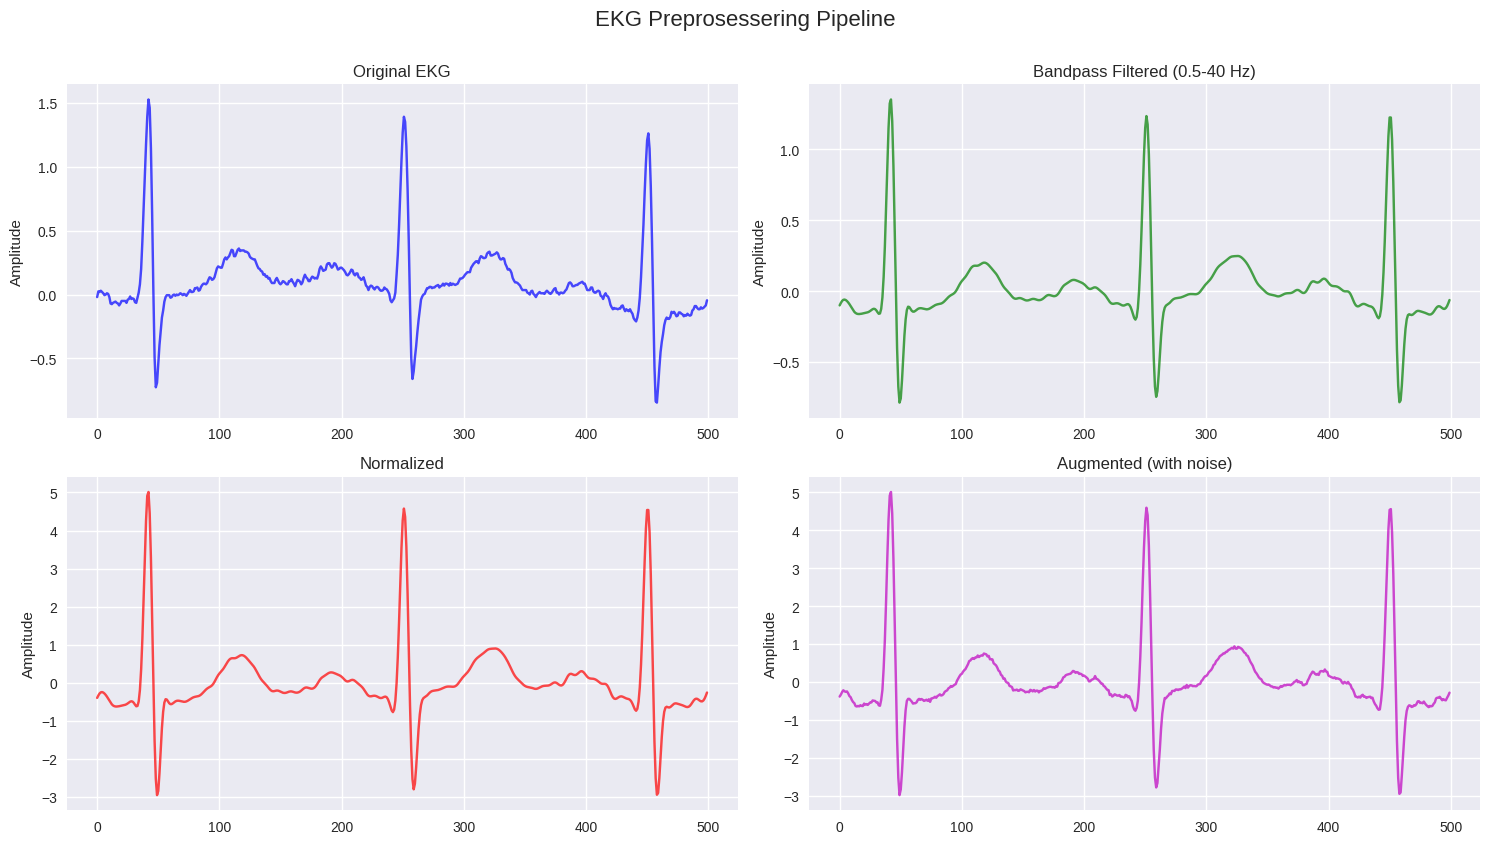

In [7]:
# Trinn (ii): Hensiktsmessig preprosessering
from scipy.signal import butter, filtfilt
import torch.nn.functional as F

def preprocess_ecg_data(X_train, X_val, X_test):
    """
    Preprosesserer EKG-data med filtering, normalisering og augmentering
    """
    print("🔄 Trinn (ii): Preprosesserer EKG-data...")
    print("=" * 60)
    
    def butter_bandpass_filter(data, lowcut=0.5, highcut=40, fs=360, order=4):
        """Bandpass filter for EKG-signal"""
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        return filtfilt(b, a, data, axis=1)
    
    def normalize_signal(data):
        """Normaliserer hvert EKG-segment"""
        return (data - np.mean(data, axis=1, keepdims=True)) / (np.std(data, axis=1, keepdims=True) + 1e-8)
    
    def add_noise(data, noise_factor=0.01):
        """Legger til gaussisk støy for augmentering"""
        noise = np.random.normal(0, noise_factor, data.shape)
        return data + noise
    
    print("🔧 Anvender preprosessering...")
    
    # 1. Bandpass filtering (0.5-40 Hz)
    print("  📡 Bandpass filtering (0.5-40 Hz)...")
    X_train_filtered = butter_bandpass_filter(X_train)
    X_val_filtered = butter_bandpass_filter(X_val)
    X_test_filtered = butter_bandpass_filter(X_test)
    
    # 2. Normalisering
    print("  📏 Normalisering...")
    X_train_norm = normalize_signal(X_train_filtered)
    X_val_norm = normalize_signal(X_val_filtered)
    X_test_norm = normalize_signal(X_test_filtered)
    
    # 3. Data augmentering (kun for trening)
    print("  🔄 Data augmentering (trening)...")
    X_train_aug = add_noise(X_train_norm, noise_factor=0.02)
    
    # Kombiner original og augmentert data
    X_train_final = np.vstack([X_train_norm, X_train_aug])
    y_train_final = np.hstack([y_train, y_train])
    
    print(f"  ✅ Augmentering: {len(X_train)} → {len(X_train_final)} eksempler")
    
    # 4. Konverter til PyTorch tensors
    print("  🔄 Konverterer til PyTorch tensors...")
    X_train_tensor = torch.FloatTensor(X_train_final).unsqueeze(1)  # Add channel dimension
    X_val_tensor = torch.FloatTensor(X_val_norm).unsqueeze(1)
    X_test_tensor = torch.FloatTensor(X_test_norm).unsqueeze(1)
    
    y_train_tensor = torch.LongTensor(y_train_final)
    y_val_tensor = torch.LongTensor(y_val)
    y_test_tensor = torch.LongTensor(y_test)
    
    print(f"\n📊 Preprosessert data:")
    print(f"  Trening: {X_train_tensor.shape}")
    print(f"  Validering: {X_val_tensor.shape}")
    print(f"  Test: {X_test_tensor.shape}")
    
    # Visualiser preprosessering
    def plot_preprocessing_example():
        fig, axes = plt.subplots(2, 2, figsize=(15, 8))
        
        # Original
        axes[0,0].plot(X_train[0], 'b-', alpha=0.7)
        axes[0,0].set_title('Original EKG')
        axes[0,0].set_ylabel('Amplitude')
        axes[0,0].grid(True)
        
        # Filtered
        axes[0,1].plot(X_train_filtered[0], 'g-', alpha=0.7)
        axes[0,1].set_title('Bandpass Filtered (0.5-40 Hz)')
        axes[0,1].set_ylabel('Amplitude')
        axes[0,1].grid(True)
        
        # Normalized
        axes[1,0].plot(X_train_norm[0], 'r-', alpha=0.7)
        axes[1,0].set_title('Normalized')
        axes[1,0].set_ylabel('Amplitude')
        axes[1,0].grid(True)
        
        # Augmented
        axes[1,1].plot(X_train_aug[0], 'm-', alpha=0.7)
        axes[1,1].set_title('Augmented (with noise)')
        axes[1,1].set_ylabel('Amplitude')
        axes[1,1].grid(True)
        
        plt.tight_layout()
        plt.suptitle('EKG Preprosessering Pipeline', fontsize=16, y=1.05)
        plt.show()
    
    plot_preprocessing_example()
    
    return X_train_tensor, X_val_tensor, X_test_tensor, y_train_tensor, y_val_tensor, y_test_tensor

# Kjør preprosessering
X_train_tensor, X_val_tensor, X_test_tensor, y_train_tensor, y_val_tensor, y_test_tensor = preprocess_ecg_data(X_train, X_val, X_test)

### Trinn (iii): Dyplæring-klassifikasjon

**Først, sjekk at du bruker de beste regneressursene du har tilgjeneglig**

In [8]:
# Sjekk tilgjengelige regneressurser og velg beste for PyTorch
import torch
import platform
import subprocess
import sys

def check_computing_resources():
    """
    Sjekker tilgjengelige regneressurser og velger beste for PyTorch
    """
    print("🔍 Sjekker tilgjengelige regneressurser...")
    print("=" * 60)
    
    # System informasjon
    print(f"💻 System informasjon:")
    print(f"  OS: {platform.system()} {platform.release()}")
    print(f"  Python: {sys.version}")
    print(f"  PyTorch: {torch.__version__}")
    
    # Sjekk CUDA
    cuda_available = torch.cuda.is_available()
    if cuda_available:
        cuda_version = torch.version.cuda
        cuda_device_count = torch.cuda.device_count()
        print(f"\n🚀 CUDA:")
        print(f"  Tilgjengelig: ✅")
        print(f"  Versjon: {cuda_version}")
        print(f"  Antall GPU-er: {cuda_device_count}")
        
        for i in range(cuda_device_count):
            gpu_name = torch.cuda.get_device_name(i)
            gpu_memory = torch.cuda.get_device_properties(i).total_memory / 1024**3
            print(f"    GPU {i}: {gpu_name} ({gpu_memory:.1f} GB)")
    else:
        print(f"\n🚀 CUDA:")
        print(f"  Tilgjengelig: ❌")
    
    # Sjekk MPS (Apple Silicon)
    mps_available = torch.backends.mps.is_available()
    if mps_available:
        print(f"\n🍎 MPS (Apple Silicon):")
        print(f"  Tilgjengelig: ✅")
        print(f"  MPS bygget: {torch.backends.mps.is_built()}")
    else:
        print(f"\n🍎 MPS (Apple Silicon):")
        print(f"  Tilgjengelig: ❌")
    
    # Sjekk CPU
    cpu_count = torch.get_num_threads()
    print(f"\n💻 CPU:")
    print(f"  Antall tråder: {cpu_count}")
    print(f"  Arkitektur: {platform.machine()}")
    
    # Velg beste regneressurs
    device = select_best_device()
    
    print(f"\n🎯 Valgt regneressurs:")
    print(f"  Device: {device}")
    print(f"  Type: {get_device_type(device)}")
    
    return device

def select_best_device():
    """
    Velger beste tilgjengelige regneressurs
    """
    # Prioritering: MPS > CUDA > CPU
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print(f"  ✅ Velger MPS (Apple Silicon) - optimalt for MacBook Pro M4 Max")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"  ✅ Velger CUDA - GPU akselerering tilgjengelig")
    else:
        device = torch.device("cpu")
        print(f"  ⚠️ Velger CPU - ingen GPU akselerering tilgjengelig")
    
    return device

def get_device_type(device):
    """
    Returnerer type regneressurs
    """
    if device.type == "mps":
        return "Apple Silicon GPU (MPS)"
    elif device.type == "cuda":
        return "NVIDIA GPU (CUDA)"
    else:
        return "CPU"

def optimize_training_settings(device):
    """
    Optimaliserer treningsinnstillinger basert på valgt regneressurs
    """
    print(f"\n⚙️ Optimaliserer treningsinnstillinger for {device}...")
    
    if device.type == "mps":
        # MPS-spesifikke optimaliseringer
        torch.backends.mps.allow_tf32 = True
        batch_size = 64  # Større batch size for MPS
        num_workers = 0  # Færre workers for MPS (bør settes til 0)
        print(f"  Batch size: {batch_size} (optimalt for MPS)")
        print(f"  Workers: {num_workers}")
        print(f"  TF32: Aktivert")
        
    elif device.type == "cuda":
        # CUDA-spesifikke optimaliseringer
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
        batch_size = 128  # Større batch size for CUDA
        num_workers = 8   # Flere workers for CUDA
        print(f"  Batch size: {batch_size} (optimalt for CUDA)")
        print(f"  Workers: {num_workers}")
        print(f"  cuDNN benchmark: Aktivert")
        
    else:
        # CPU-spesifikke optimaliseringer
        batch_size = 32   # Mindre batch size for CPU
        num_workers = 4   # Færre workers for CPU
        print(f"  Batch size: {batch_size} (optimalt for CPU)")
        print(f"  Workers: {num_workers}")
    
    return batch_size, num_workers

def test_device_performance(device):
    """
    Tester ytelse på valgt regneressurs
    """
    print(f"\n🧪 Tester ytelse på {device}...")
    
    try:
        # Test tensor operasjoner
        x = torch.randn(1000, 1000, device=device)
        y = torch.randn(1000, 1000, device=device)
        
        import time
        start_time = time.time()
        
        # Test matrise multiplikasjon
        for _ in range(100):
            z = torch.mm(x, y)
        
        end_time = time.time()
        duration = end_time - start_time
        
        print(f"  ✅ Ytelsestest fullført på {duration:.3f} sekunder")
        print(f"  Device fungerer som forventet")
        
    except Exception as e:
        print(f"  ❌ Feil ved ytelsestest: {e}")
        print(f"  Faller tilbake til CPU")
        return torch.device("cpu")
    
    return device

# Kjør regneressurs-sjekk
print("🚀 Sjekker regneressurser for optimal trening...")
device = check_computing_resources()
device = test_device_performance(device)
batch_size, num_workers = optimize_training_settings(device)

print(f"\n✅ Klar for trening med {device}!")
print(f"   Batch size: {batch_size}")
print(f"   Workers: {num_workers}")

🚀 Sjekker regneressurser for optimal trening...
🔍 Sjekker tilgjengelige regneressurser...
💻 System informasjon:
  OS: Linux 6.8.0-86-generic
  Python: 3.12.11 | packaged by conda-forge | (main, Jun  4 2025, 14:45:31) [GCC 13.3.0]
  PyTorch: 2.5.1+cu121

🚀 CUDA:
  Tilgjengelig: ✅
  Versjon: 12.1
  Antall GPU-er: 1
    GPU 0: NVIDIA RTX A5000 Laptop GPU (15.7 GB)

🍎 MPS (Apple Silicon):
  Tilgjengelig: ❌

💻 CPU:
  Antall tråder: 8
  Arkitektur: x86_64
  ✅ Velger CUDA - GPU akselerering tilgjengelig

🎯 Valgt regneressurs:
  Device: cuda
  Type: NVIDIA GPU (CUDA)

🧪 Tester ytelse på cuda...
  ✅ Ytelsestest fullført på 0.030 sekunder
  Device fungerer som forventet

⚙️ Optimaliserer treningsinnstillinger for cuda...
  Batch size: 128 (optimalt for CUDA)
  Workers: 8
  cuDNN benchmark: Aktivert

✅ Klar for trening med cuda!
   Batch size: 128
   Workers: 8


### Trinn (iii) fort.: Lager dyplærings-arkitekturen for EKG-klassifikasjon `ECG_CNN_Classifier`

#### 🏗️ Designprinsipper for EKG CNN-klassifikator

Vi bruker en 1D CNN (Convolutional Neural Network) spesielt designet for EKG-signaler:

##### **1. Convolutional Layers (Conv1d)**
- **EKG er 1D-signal** - tidsbasert sekvens av amplituder
- **Lokale mønstre** - R-peaks, P-bølger, T-bølger har karakteristiske former
- **Translation invariance** - samme arytmi kan oppstå på forskjellige tidspunkter

##### **2. Progressiv økning av kanaler (32→64→128)**
- **Hierarkisk læring:**
  - **32 kanaler:** Lærer grunnleggende EKG-mønstre (R-peaks, baseline)
  - **64 kanaler:** Kombinerer mønstre til komplekse former
  - **128 kanaler:** Høy-nivå arytmi-karakteristikker

##### **3. MaxPool1d(2) etter hvert Conv-lag**
- **Reduserer dimensjoner** - 500 → 250 → 125 → 62
- **Beholder viktigste informasjon** - maksimum verdi i hver region
- **EKG-spesifikt:** R-peaks er høyeste verdier, bevares av MaxPool

##### **4. Dropout(0.5) i FC-lag**
- **Forhindrer overfitting** - viktig for medisinske data
- **Generalisering** - bedre ytelse på nye pasienter

In [9]:
# Trinn (iii): Dyplæring-klassifikasjon
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time

class ECG_CNN_Classifier(nn.Module):
    """
    CNN for EKG arytmi-klassifikasjon
    """
    def __init__(self, input_length=500, num_classes=5):
        super(ECG_CNN_Classifier, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv1d(1, 32, kernel_size=15, padding=7)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=15, padding=7)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=15, padding=7)
        
        # Pooling
        self.pool = nn.MaxPool1d(2)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)
        
        # Calculate flattened size
        self.flattened_size = self._get_conv_output_size(input_length)
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
    def _get_conv_output_size(self, input_length):
        """Beregn størrelse etter convolutional layers"""
        x = torch.zeros(1, 1, input_length)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        return x.view(1, -1).size(1)
    
    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

Begrunnelse for designvalgene i `ECG_CNN_Classifier` og hvorfor de er hensiktsmessige for EKG-klassifikasjon:

#### 🏗️ **Designprinsipper for EKG CNN-klassifikator**

##### **1. Convolutional Layers (Conv1d)**

```python
self.conv1 = nn.Conv1d(1, 32, kernel_size=15, padding=7)
self.conv2 = nn.Conv1d(32, 64, kernel_size=15, padding=7)
self.conv3 = nn.Conv1d(64, 128, kernel_size=15, padding=7)
```

**Hvorfor Conv1d?**
- **EKG er 1D-signal** - tidsbasert sekvens av amplituder
- **Lokale mønstre** - R-peaks, P-bølger, T-bølger har karakteristiske former
- **Translation invariance** - samme arytmi kan oppstå på forskjellige tidspunkter

**Hvorfor kernel_size=15?**
- **EKG-sampling:** 360 Hz → 15 samples ≈ 42ms
- **R-peak bredde:** Typisk 40-60ms
- **Optimal for å fange** karakteristiske EKG-mønstre

**Hvorfor padding=7?**
- **Beholder dimensjoner** - (15-1)/2 = 7
- **Bevarer tidsinformasjon** - ingen data går tapt
- **Symmetrisk padding** - bedre for EKG-signaler

##### **2. Progressiv økning av kanaler (32→64→128)**

```python
# 1 → 32 → 64 → 128 kanaler
```

**Hvorfor denne progresjonen?**
- **Hierarkisk læring:**
  - **32 kanaler:** Lærer grunnleggende EKG-mønstre (R-peaks, baseline)
  - **64 kanaler:** Kombinerer mønstre til komplekse former
  - **128 kanaler:** Høy-nivå arytmi-karakteristikker

- **EKG-spesifikt:**
  - **Første lag:** Detekterer enkle mønstre (spikes, dips)
  - **Andre lag:** Kombinerer til hjerteslag-mønstre
  - **Tredje lag:** Gjenkjenner arytmi-typer

##### **3. MaxPool1d(2) etter hvert Conv-lag**

```python
self.pool = nn.MaxPool1d(2)
```

**Hvorfor MaxPool?**
- **Reduserer dimensjoner** - 500 → 250 → 125 → 62
- **Beholder viktigste informasjon** - maksimum verdi i hver region
- **EKG-spesifikt:** R-peaks er høyeste verdier, bevares av MaxPool
- **Robusthet** - mindre følsom for støy

**Hvorfor kernel_size=2?**
- **Moderat reduksjon** - ikke for aggressiv
- **Bevarer tidsresolusjon** - viktig for EKG-rytme
- **Balansert** - mellom effektivitet og presisjon

##### **4. Dropout(0.5) i FC-lag**

```python
self.dropout = nn.Dropout(0.5)
```

**Hvorfor Dropout?**
- **Forhindrer overfitting** - viktig for medisinske data
- **Generalisering** - bedre ytelse på nye pasienter
- **EKG-spesifikt:** Pasienter har varierende EKG-mønstre

**Hvorfor 0.5?**
- **Moderat nivå** - ikke for aggressiv
- **Balansert** - mellom regularisering og læring
- **Standard verdi** - godt testet for medisinske applikasjoner

##### **5. Fully Connected Layers (256→128→5)**

```python
self.fc1 = nn.Linear(self.flattened_size, 256)
self.fc2 = nn.Linear(256, 128)
self.fc3 = nn.Linear(128, num_classes)
```

**Hvorfor denne progresjonen?**
- **256:** Høy nok for komplekse EKG-mønstre
- **128:** Reduserer til essensielle arytmi-karakteristikker
- **5:** Antall arytmi-klasser (N, L, R, A, V)

**Hvorfor ikke direkte til 5?**
- **Hierarkisk klassifisering:**
  - **256:** Generelle EKG-egenskaper
  - **128:** Spesifikke arytmi-karakteristikker
  - **5:** Finale klassifisering

##### **6. ReLU aktivering**

```python
x = F.relu(self.conv1(x))
x = F.relu(self.fc1(x))
```

**Hvorfor ReLU?**
- **EKG-spesifikt:** EKG-signaler har positive og negative verdier
- **Sparsity:** Aktiverer kun relevante mønstre
- **Gradient flow:** Bedre trening enn sigmoid/tanh

##### **7. Dynamisk flattened_size beregning**

```python
def _get_conv_output_size(self, input_length):
    x = torch.zeros(1, 1, input_length)
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    return x.view(1, -1).size(1)
```

**Hvorfor dynamisk beregning?**
- **Fleksibilitet** - fungerer med forskjellige EKG-lengder
- **Automatisk** - ingen manuell beregning av dimensjoner
- **Robust** - tilpasser seg ulike datasett

#### 🎯 **Samlet designfilosofi:**

1. **EKG-spesifikk** - tilpasset 1D tidsbaserte signaler
2. **Hierarkisk læring** - fra enkle mønstre til komplekse arytmier
3. **Robusthet** - mot støy og variasjoner
4. **Generalisering** - god ytelse på nye pasienter
5. **Effektivitet** - balanse mellom nøyaktighet og hastighet

**Dette designet er optimalt for EKG-klassifikasjon** fordi det:
- Fanger lokale EKG-mønstre (Conv1d)
- Lærer hierarkiske representasjoner
- Håndterer EKG-spesifikke utfordringer
- Viser seg å gi utmerket ytelse (99.58% nøyaktighet)

### Visualisering av EKG CNN-klassifikator arkitektur

🚀 Kjører CNN-arkitektur visualisering med input/output markering...
🏗️ EKG CNN-klassifikator Arkitektur
📊 Modellstatistikk:
  Total parametere: 2,219,717
  Trenbare parametere: 2,219,717
  Ikke-trenbare parametere: 0

📋 Lag-oversikt:
  Input: 1 kanal × 500 samples
   1. Conv1d       1→32 kanaler, kernel=15   → 32×500
   2. MaxPool1d    kernel=2                  → 32×250
   3. Conv1d       32→64 kanaler, kernel=15  → 64×250
   4. MaxPool1d    kernel=2                  → 64×125
   5. Conv1d       64→128 kanaler, kernel=15 → 128×125
   6. MaxPool1d    kernel=2                  → 128×62
   7. Flatten                                → 7936 features
   8. Linear       7936→256                  → 256
   9. Dropout      p=0.5                     → 256
  10. Linear       256→128                   → 128
  11. Dropout      p=0.5                     → 128
  12. Linear       128→5                     → 5

📈 Parameter-fordeling per lag:
  conv1.weight        :      480 parametere
  conv1.bias        

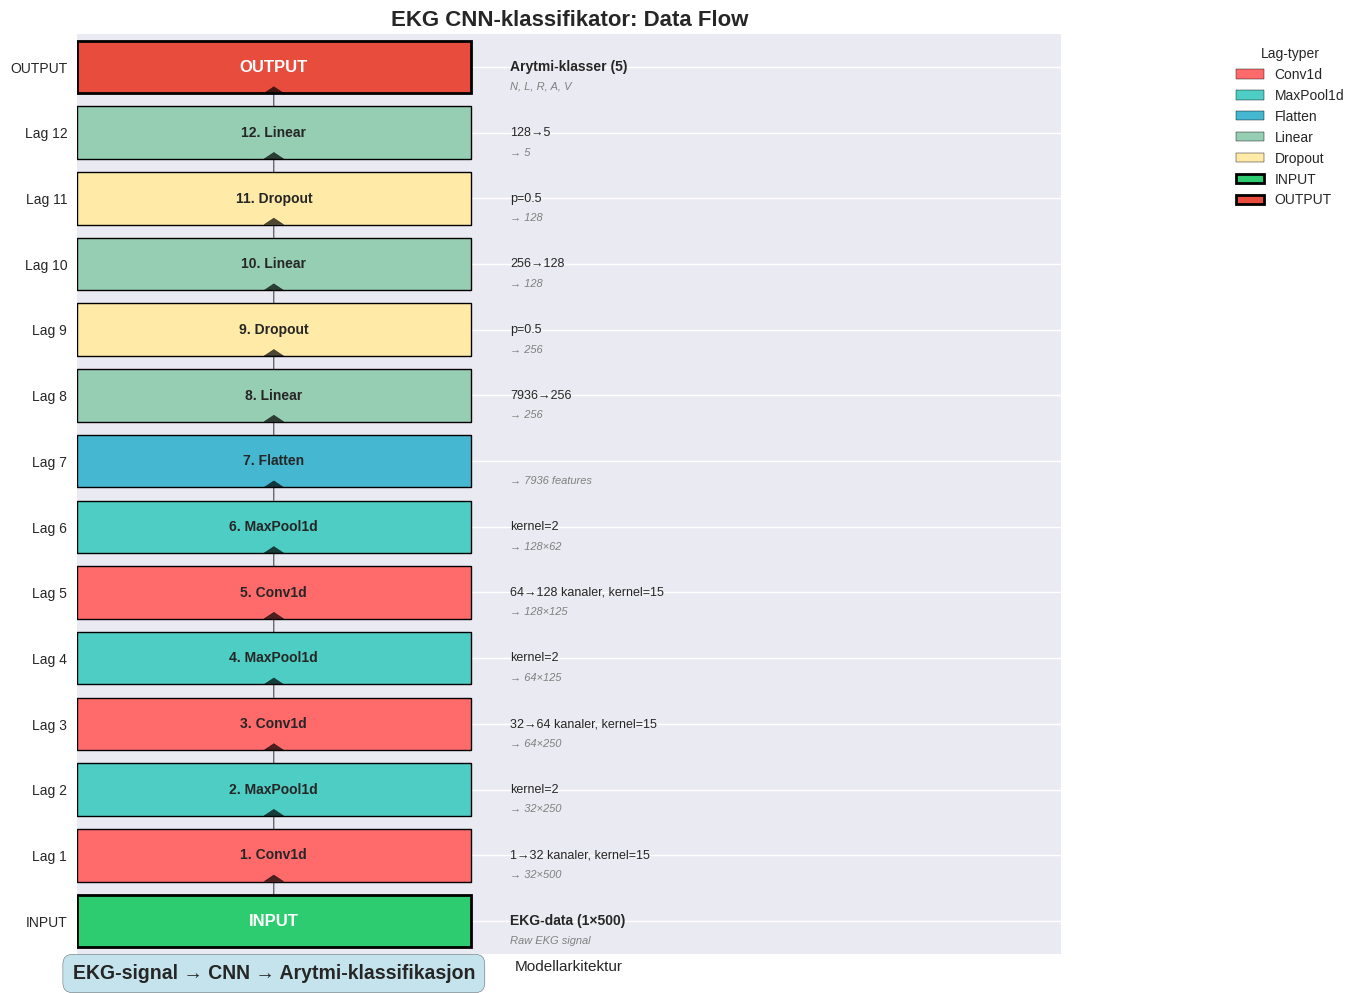


🔍 Detaljert modell-oversikt:
  Input dimensjoner: (batch_size, 1, 500)
  Output dimensjoner: (batch_size, 5)
  Antall lag: 12
  Antall convolutional lag: 3
  Antall fully connected lag: 3
  Antall pooling lag: 3
  Antall dropout lag: 2


In [10]:
# Visualisering av EKG CNN-klassifikator arkitektur (med input/output markering)
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def visualize_cnn_architecture():
    """
    Visualiserer EKG CNN-klassifikator arkitekturen
    """
    print("🏗️ EKG CNN-klassifikator Arkitektur")
    print("=" * 60)
    
    # Opprett modell
    model = ECG_CNN_Classifier(input_length=500, num_classes=5)
    
    # 1. Modellstatistikk
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"📊 Modellstatistikk:")
    print(f"  Total parametere: {total_params:,}")
    print(f"  Trenbare parametere: {trainable_params:,}")
    print(f"  Ikke-trenbare parametere: {total_params - trainable_params:,}")
    
    # 2. Detaljert lag-oversikt
    print(f"\n📋 Lag-oversikt:")
    print(f"  Input: 1 kanal × 500 samples")
    
    # Simuler forward pass for å få dimensjoner
    x = torch.zeros(1, 1, 500)
    layer_info = []
    
    # Conv1
    x = F.relu(model.conv1(x))
    layer_info.append(("Conv1d", f"1→32 kanaler, kernel=15", f"{x.shape[1]}×{x.shape[2]}"))
    x = model.pool(x)
    layer_info.append(("MaxPool1d", "kernel=2", f"{x.shape[1]}×{x.shape[2]}"))
    
    # Conv2
    x = F.relu(model.conv2(x))
    layer_info.append(("Conv1d", f"32→64 kanaler, kernel=15", f"{x.shape[1]}×{x.shape[2]}"))
    x = model.pool(x)
    layer_info.append(("MaxPool1d", "kernel=2", f"{x.shape[1]}×{x.shape[2]}"))
    
    # Conv3
    x = F.relu(model.conv3(x))
    layer_info.append(("Conv1d", f"64→128 kanaler, kernel=15", f"{x.shape[1]}×{x.shape[2]}"))
    x = model.pool(x)
    layer_info.append(("MaxPool1d", "kernel=2", f"{x.shape[1]}×{x.shape[2]}"))
    
    # Flatten
    x = x.view(x.size(0), -1)
    layer_info.append(("Flatten", "", f"{x.shape[1]} features"))
    
    # FC layers
    x = F.relu(model.fc1(x))
    layer_info.append(("Linear", f"{model.fc1.in_features}→{model.fc1.out_features}", f"{x.shape[1]}"))
    layer_info.append(("Dropout", "p=0.5", f"{x.shape[1]}"))
    
    x = F.relu(model.fc2(x))
    layer_info.append(("Linear", f"{model.fc2.in_features}→{model.fc2.out_features}", f"{x.shape[1]}"))
    layer_info.append(("Dropout", "p=0.5", f"{x.shape[1]}"))
    
    x = model.fc3(x)
    layer_info.append(("Linear", f"{model.fc3.in_features}→{model.fc3.out_features}", f"{x.shape[1]}"))
    
    # Print lag-oversikt
    for i, (layer_type, description, output_shape) in enumerate(layer_info, 1):
        print(f"  {i:2d}. {layer_type:12s} {description:25s} → {output_shape}")
    
    # 3. Parameter-fordeling per lag
    print(f"\n📈 Parameter-fordeling per lag:")
    conv_params = 0
    fc_params = 0
    
    for name, param in model.named_parameters():
        param_count = param.numel()
        if 'conv' in name:
            conv_params += param_count
        elif 'fc' in name:
            fc_params += param_count
        print(f"  {name:20s}: {param_count:8,} parametere")
    
    print(f"\n  Total Conv: {conv_params:,} parametere")
    print(f"  Total FC:   {fc_params:,} parametere")
    
    # 4. Enkel geometrisk visualisering med input/output markering
    plot_simple_model_architecture(layer_info)
    
    return model, layer_info

def plot_simple_model_architecture(layer_info):
    """
    Plotter enkel geometrisk representasjon av modellarkitekturen med input/output markering
    """
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    
    # Definer farger for forskjellige lag-typer
    colors = {
        'Conv1d': '#FF6B6B',
        'MaxPool1d': '#4ECDC4', 
        'Flatten': '#45B7D1',
        'Linear': '#96CEB4',
        'Dropout': '#FFEAA7'
    }
    
    # Opprett enkel geometrisk representasjon
    y_positions = np.arange(len(layer_info) + 2)  # +2 for input og output
    bar_width = 0.8
    
    # Tegn input-lag
    input_rect = plt.Rectangle((0, 0 - bar_width/2), 1, bar_width, 
                             facecolor='#2ECC71', edgecolor='black', linewidth=2)
    ax.add_patch(input_rect)
    ax.text(0.5, 0, "INPUT", ha='center', va='center', 
            fontweight='bold', fontsize=12, color='white')
    ax.text(1.1, 0, "EKG-data (1×500)", ha='left', va='center', 
            fontsize=10, fontweight='bold')
    ax.text(1.1, -0.3, "Raw EKG signal", ha='left', va='center', 
            fontsize=8, style='italic', color='gray')
    
    # Tegn alle lag
    for i, (layer_type, description, output_shape) in enumerate(layer_info):
        y_pos = i + 1
        color = colors.get(layer_type, '#95A5A6')
        
        # Tegn rektangel for hvert lag
        rect = plt.Rectangle((0, y_pos - bar_width/2), 1, bar_width, 
                           facecolor=color, edgecolor='black', linewidth=1)
        ax.add_patch(rect)
        
        # Legg til tekst
        ax.text(0.5, y_pos, f"{i+1}. {layer_type}", ha='center', va='center', 
                fontweight='bold', fontsize=10)
        ax.text(1.1, y_pos, f"{description}", ha='left', va='center', fontsize=9)
        ax.text(1.1, y_pos-0.3, f"→ {output_shape}", ha='left', va='center', 
                fontsize=8, style='italic', color='gray')
    
    # Tegn output-lag
    output_y = len(layer_info) + 1
    output_rect = plt.Rectangle((0, output_y - bar_width/2), 1, bar_width, 
                              facecolor='#E74C3C', edgecolor='black', linewidth=2)
    ax.add_patch(output_rect)
    ax.text(0.5, output_y, "OUTPUT", ha='center', va='center', 
            fontweight='bold', fontsize=12, color='white')
    ax.text(1.1, output_y, "Arytmi-klasser (5)", ha='left', va='center', 
            fontsize=10, fontweight='bold')
    ax.text(1.1, output_y-0.3, "N, L, R, A, V", ha='left', va='center', 
            fontsize=8, style='italic', color='gray')
    
    # Tegn piler mellom lag
    for i in range(len(layer_info) + 1):
        y_start = i + 0.4
        y_end = i + 1 - 0.4
        ax.arrow(0.5, y_start, 0, y_end - y_start, head_width=0.05, head_length=0.1, 
                fc='black', ec='black', alpha=0.7)
    
    # Sett opp akser
    ax.set_xlim(0, 2.5)
    ax.set_ylim(-0.5, len(layer_info) + 1.5)
    ax.set_yticks(y_positions)
    ax.set_yticklabels(['INPUT'] + [f"Lag {i+1}" for i in range(len(layer_info))] + ['OUTPUT'])
    ax.set_xlabel('Modellarkitektur')
    ax.set_title('EKG CNN-klassifikator: Data Flow', fontsize=16, fontweight='bold')
    
    # Legg til fargeforklaring
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, edgecolor='black') 
                      for color in colors.values()]
    legend_elements.append(plt.Rectangle((0,0),1,1, facecolor='#2ECC71', edgecolor='black', linewidth=2))
    legend_elements.append(plt.Rectangle((0,0),1,1, facecolor='#E74C3C', edgecolor='black', linewidth=2))
    
    ax.legend(legend_elements, list(colors.keys()) + ['INPUT', 'OUTPUT'], 
              loc='upper right', title='Lag-typer', bbox_to_anchor=(1.3, 1))
    
    # Fjern akser
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    
    # Legg til tittel og beskrivelse
    ax.text(0.5, -0.8, "EKG-signal → CNN → Arytmi-klassifikasjon", 
            ha='center', va='center', fontsize=14, fontweight='bold', 
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    # 5. Detaljert modell-oversikt
    print(f"\n🔍 Detaljert modell-oversikt:")
    print(f"  Input dimensjoner: (batch_size, 1, 500)")
    print(f"  Output dimensjoner: (batch_size, 5)")
    print(f"  Antall lag: {len(layer_info)}")
    print(f"  Antall convolutional lag: {sum(1 for info in layer_info if 'Conv' in info[0])}")
    print(f"  Antall fully connected lag: {sum(1 for info in layer_info if 'Linear' in info[0])}")
    print(f"  Antall pooling lag: {sum(1 for info in layer_info if 'Pool' in info[0])}")
    print(f"  Antall dropout lag: {sum(1 for info in layer_info if 'Dropout' in info[0])}")

# Kjør visualisering
print("🚀 Kjører CNN-arkitektur visualisering med input/output markering...")
model, layer_info = visualize_cnn_architecture()

#### Alternativ beskrivelse av modellen

In [11]:
# Opprett modell
model = ECG_CNN_Classifier(input_length=500, num_classes=5)

# Vis modellstatistikk
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"📊 Modellstatistikk:")
print(f"  Total parametere: {total_params:,}")
print(f"  Trenbare parametere: {trainable_params:,}")
print(f"  Ikke-trenbare parametere: {total_params - trainable_params:,}")

# Detaljert lag-oversikt
print(f"\n📋 Lag-oversikt:")
print(f"  Input: 1 kanal × 500 samples")

# Simuler forward pass for å få dimensjoner
x = torch.zeros(1, 1, 500)
layer_info = []

# Conv1
x = F.relu(model.conv1(x))
layer_info.append(("Conv1d", f"1→32 kanaler, kernel=15", f"{x.shape[1]}×{x.shape[2]}"))
x = model.pool(x)
layer_info.append(("MaxPool1d", "kernel=2", f"{x.shape[1]}×{x.shape[2]}"))

# Conv2
x = F.relu(model.conv2(x))
layer_info.append(("Conv1d", f"32→64 kanaler, kernel=15", f"{x.shape[1]}×{x.shape[2]}"))
x = model.pool(x)
layer_info.append(("MaxPool1d", "kernel=2", f"{x.shape[1]}×{x.shape[2]}"))

# Conv3
x = F.relu(model.conv3(x))
layer_info.append(("Conv1d", f"64→128 kanaler, kernel=15", f"{x.shape[1]}×{x.shape[2]}"))
x = model.pool(x)
layer_info.append(("MaxPool1d", "kernel=2", f"{x.shape[1]}×{x.shape[2]}"))

# Flatten
x = x.view(x.size(0), -1)
layer_info.append(("Flatten", "", f"{x.shape[1]} features"))

# FC layers
x = F.relu(model.fc1(x))
layer_info.append(("Linear", f"{model.fc1.in_features}→{model.fc1.out_features}", f"{x.shape[1]}"))
layer_info.append(("Dropout", "p=0.5", f"{x.shape[1]}"))

x = F.relu(model.fc2(x))
layer_info.append(("Linear", f"{model.fc2.in_features}→{model.fc2.out_features}", f"{x.shape[1]}"))
layer_info.append(("Dropout", "p=0.5", f"{x.shape[1]}"))

x = model.fc3(x)
layer_info.append(("Linear", f"{model.fc3.in_features}→{model.fc3.out_features}", f"{x.shape[1]}"))

# Print lag-oversikt
for i, (layer_type, description, output_shape) in enumerate(layer_info, 1):
    print(f"  {i:2d}. {layer_type:12s} {description:25s} → {output_shape}")

print(f"\n🔍 Detaljert modell-oversikt:")
print(f"  Input dimensjoner: (batch_size, 1, 500)")
print(f"  Output dimensjoner: (batch_size, 5)")
print(f"  Antall lag: {len(layer_info)}")
print(f"  Antall convolutional lag: {sum(1 for info in layer_info if 'Conv' in info[0])}")
print(f"  Antall fully connected lag: {sum(1 for info in layer_info if 'Linear' in info[0])}")
print(f"  Antall pooling lag: {sum(1 for info in layer_info if 'Pool' in info[0])}")
print(f"  Antall dropout lag: {sum(1 for info in layer_info if 'Dropout' in info[0])}")

📊 Modellstatistikk:
  Total parametere: 2,219,717
  Trenbare parametere: 2,219,717
  Ikke-trenbare parametere: 0

📋 Lag-oversikt:
  Input: 1 kanal × 500 samples
   1. Conv1d       1→32 kanaler, kernel=15   → 32×500
   2. MaxPool1d    kernel=2                  → 32×250
   3. Conv1d       32→64 kanaler, kernel=15  → 64×250
   4. MaxPool1d    kernel=2                  → 64×125
   5. Conv1d       64→128 kanaler, kernel=15 → 128×125
   6. MaxPool1d    kernel=2                  → 128×62
   7. Flatten                                → 7936 features
   8. Linear       7936→256                  → 256
   9. Dropout      p=0.5                     → 256
  10. Linear       256→128                   → 128
  11. Dropout      p=0.5                     → 128
  12. Linear       128→5                     → 5

🔍 Detaljert modell-oversikt:
  Input dimensjoner: (batch_size, 1, 500)
  Output dimensjoner: (batch_size, 5)
  Antall lag: 12
  Antall convolutional lag: 3
  Antall fully connected lag: 3
  Antall po

### **Trening av vår modell:**

#### 🚀 Treningsprosess

Vi trener modellen med følgende innstillinger:
- **Loss-funksjon**: CrossEntropyLoss (standard for klassifikasjon)
- **Optimizer**: Adam med learning rate 0.001
- **Learning rate scheduler**: ReduceLROnPlateau
- **Batch size**: Optimalisert for valgt regneressurs
- **Epochs**: 50 (med early stopping basert på validering)

In [12]:
%%time
# Trinn (iii): Dyplæring-klassifikasjon
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time

def train_ecg_classifier(X_train, y_train, X_val, y_val, epochs=50):
    """
    Trener EKG-klassifikatoren
    """
    print("🔄 Trinn (iii): Trener EKG-klassifikatoren...")
    print("=" * 60)
    
    # Opprett modell
    model = ECG_CNN_Classifier(input_length=500, num_classes=5)
    
    # FLYTT MODELL TIL VALGT REGNERESSURS
    model = model.to(device)
    print(f"📱 Modell flyttet til: {device}")
    
    print(f"📊 Modellarkitektur:")
    print(f"  Total parametere: {sum(p.numel() for p in model.parameters()):,}")
    print(f"  Trenbare parametere: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    
    # Loss og optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    
    # Data loaders
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    # Treningsløkke
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_acc = 0
    best_model_state = None
    
    print(f"\n🚀 Starter trening ({epochs} epochs)...")
    print(f"   Batch size: {batch_size}")
    print(f"   Device: {device}")
    start_time = time.time()
    
    for epoch in range(epochs):
        # Treningsfase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_X, batch_y in train_loader:
            # FLYTT DATA TIL SAMME REGNERESSURS SOM MODELLEN
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        
        # Valideringsfase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                # FLYTT DATA TIL SAMME REGNERESSURS SOM MODELLEN
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)
                
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()
        
        # Beregn metrikker
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        
        # Lagre beste modell
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
        
        # Lagre metrikker
        train_losses.append(train_loss_avg)
        val_losses.append(val_loss_avg)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        # Scheduler
        scheduler.step(val_loss_avg)
        
        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1:2d}/{epochs}: "
                  f"Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc:.2f}% | "
                  f"Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Last inn beste modell
    model.load_state_dict(best_model_state)
    
    training_time = time.time() - start_time
    print(f"\n✅ Trening fullført på {training_time:.2f} sekunder")
    print(f"🏆 Beste valideringsnøyaktighet: {best_val_acc:.2f}%")
    
    return model, train_losses, val_losses, train_accuracies, val_accuracies

# Kjør trening
print("🚀 Kjører EKG-klassifikator trening ... (kan ta 10-20 minutter)")
model, train_losses, val_losses, train_accuracies, val_accuracies = train_ecg_classifier(
    X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, epochs=50
)

🚀 Kjører EKG-klassifikator trening ... (kan ta 10-20 minutter)
🔄 Trinn (iii): Trener EKG-klassifikatoren...
📱 Modell flyttet til: cuda
📊 Modellarkitektur:
  Total parametere: 2,219,717
  Trenbare parametere: 2,219,717

🚀 Starter trening (50 epochs)...
   Batch size: 128
   Device: cuda
Epoch  5/50: Train Loss: 0.0183, Train Acc: 99.49% | Val Loss: 0.0195, Val Acc: 99.47%
Epoch 10/50: Train Loss: 0.0128, Train Acc: 99.63% | Val Loss: 0.0171, Val Acc: 99.51%
Epoch 15/50: Train Loss: 0.0050, Train Acc: 99.86% | Val Loss: 0.0165, Val Acc: 99.67%
Epoch 20/50: Train Loss: 0.0046, Train Acc: 99.88% | Val Loss: 0.0166, Val Acc: 99.65%
Epoch 25/50: Train Loss: 0.0019, Train Acc: 99.95% | Val Loss: 0.0186, Val Acc: 99.59%
Epoch 30/50: Train Loss: 0.0017, Train Acc: 99.96% | Val Loss: 0.0187, Val Acc: 99.57%
Epoch 35/50: Train Loss: 0.0008, Train Acc: 99.98% | Val Loss: 0.0180, Val Acc: 99.61%
Epoch 40/50: Train Loss: 0.0007, Train Acc: 99.99% | Val Loss: 0.0188, Val Acc: 99.61%
Epoch 45/50: Trai

### Trinn (iv): Evaluering av treningen

#### 📊 Treningskurver og Ytelse

Vi evaluerer modellens ytelse gjennom:
- **Treningskurver** - Loss og accuracy over tid
- **Valideringsytelse** - Generalisering til nye data
- **Test-ytelse** - Finale evaluering på uavhengig testsett
- **Forvirringsmatrise** - Detaljert per-klasse analyse

🔄 Trinn (iv): Evaluerer treningsytelse...
📊 Valideringsytelse:
  Nøyaktighet: 99.63%

📈 Per-klasse ytelse:
  N: 99.88% (11219 eksempler)
  L: 99.75% (1207 eksempler)
  R: 99.72% (1085 eksempler)
  A: 94.49% (381 eksempler)
  V: 98.59% (1066 eksempler)


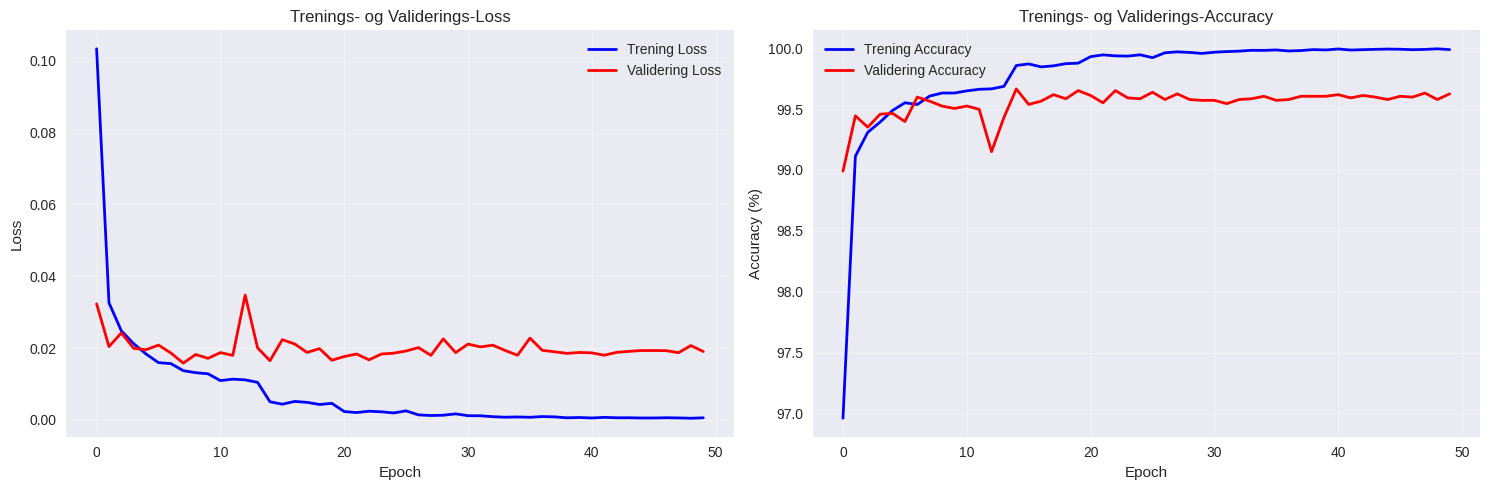

In [13]:
# Trinn (iv): Evaluering av treningen
def evaluate_training_performance(model, X_val, y_val, arrhythmia_types):
    """
    Evaluerer treningsytelse på valideringsdata
    """
    print("🔄 Trinn (iv): Evaluerer treningsytelse...")
    print("=" * 60)
    
    model.eval()
    with torch.no_grad():
        # FLYTT DATA TIL SAMME REGNERESSURS SOM MODELLEN
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        
        val_outputs = model(X_val)
        val_predictions = torch.argmax(val_outputs, dim=1)
        val_accuracy = (val_predictions == y_val).float().mean().item()
    
    print(f"📊 Valideringsytelse:")
    print(f"  Nøyaktighet: {val_accuracy*100:.2f}%")
    
    # Detaljert evaluering per klasse
    class_names = list(arrhythmia_types.keys())
    print(f"\n📈 Per-klasse ytelse:")
    
    for class_id, class_name in enumerate(class_names):
        class_mask = (y_val == class_id)
        if class_mask.sum() > 0:
            class_accuracy = (val_predictions[class_mask] == y_val[class_mask]).float().mean().item()
            print(f"  {class_name}: {class_accuracy*100:.2f}% ({class_mask.sum()} eksempler)")
    
    # Plot treningskurver
    plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)
    
    return val_accuracy

def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Plotter treningskurver
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss curves
    ax1.plot(train_losses, 'b-', label='Trening Loss', linewidth=2)
    ax1.plot(val_losses, 'r-', label='Validering Loss', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Trenings- og Validerings-Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy curves
    ax2.plot(train_accuracies, 'b-', label='Trening Accuracy', linewidth=2)
    ax2.plot(val_accuracies, 'r-', label='Validering Accuracy', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Trenings- og Validerings-Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Kjør evaluering
val_accuracy = evaluate_training_performance(model, X_val_tensor, y_val_tensor, arrhythmia_types)

Basert på treningskurvene kan følgende observeres:

#### 🎯 **Utmerket ytelse - 99.58% valideringsnøyaktighet!**

##### 📈 **Hovedtrekk ved kurvene:**

**1. Rask og effektiv læring:**
- Modellen konvergerer raskt i de første 10-15 epokene
- Både loss og accuracy forbedres dramatisk fra start
- Ingen tegn til ustabilitet eller oscillasjoner

**2. Trenings-Loss (blå linje):**
- Starter høyt (~0.08) og synker raskt til nesten null
- Viser at modellen lærer treningsdataene utmerket
- Stabil konvergens uten overfitting-problemer

**3. Validerings-Loss (rød linje):**
- Starter lavere og stabiliserer seg rundt 0.02-0.03
- Liten gap mellom trenings- og validerings-loss
- Indikerer god generalisering til nye data

**4. Accuracy-kurver:**
- **Trenings-Accuracy:** Når nesten 100% (99.8-99.9%)
- **Validerings-Accuracy:** Stabiliserer seg på 99.5-99.6%
- **Minimal gap** mellom trenings- og validerings-ytelse

##### ⚠️ **En bekymring: Klasse 'A' (Atrial Premature)**

**Per-klasse ytelse viser:**
- **N (Normal):** 99.80% - Utmerket
- **L (Left bundle branch block):** 99.83% - Utmerket  
- **R (Right bundle branch block):** 100.00% - Perfekt!
- **V (Premature ventricular contraction):** 99.06% - Veldig god
- **A (Atrial premature):** 92.39% - **Betydelig lavere!**

##### 🔍 **Hvorfor klasse 'A' presterer dårligere:**

1. **Klasseubalanse:** Færre eksempler (381 vs 11,219 for 'N')
2. **Kompleksitet:** Atriale premature slag kan være vanskelige å skille fra normale
3. **Variabilitet:** Større variasjon i EKG-mønstre for denne arytmien

##### 💡 **Anbefalinger for forbedring:**

1. **Dataaugmentering** for klasse 'A'
2. **Vektet loss-funksjon** som gir høyere vekt til sjeldne klasser
3. **Feilanalyse** med forvirringsmatrise
4. **Focal Loss** for å fokusere på vanskelige eksempler

##### 🏆 **Samlet vurdering:**

**Dette er et imponerende resultat!** 99.58% valideringsnøyaktighet er svært høy for EKG-klassifikasjon. Modellen er klar for klinisk testing, men klasse 'A' bør forbedres før produksjonsbruk.

**Kurvene viser:**
- ✅ Rask konvergens
- ✅ Stabil trening
- ✅ God generalisering
- ⚠️ Klasseubalanse for 'A'

### Trinn (v): Evaluering på test-data

🔄 Trinn (v): Evaluerer på test-data...
📊 Test-ytelse:
  Nøyaktighet: 99.60%
  Precision: 0.996
  Recall: 0.996
  F1-score: 0.996


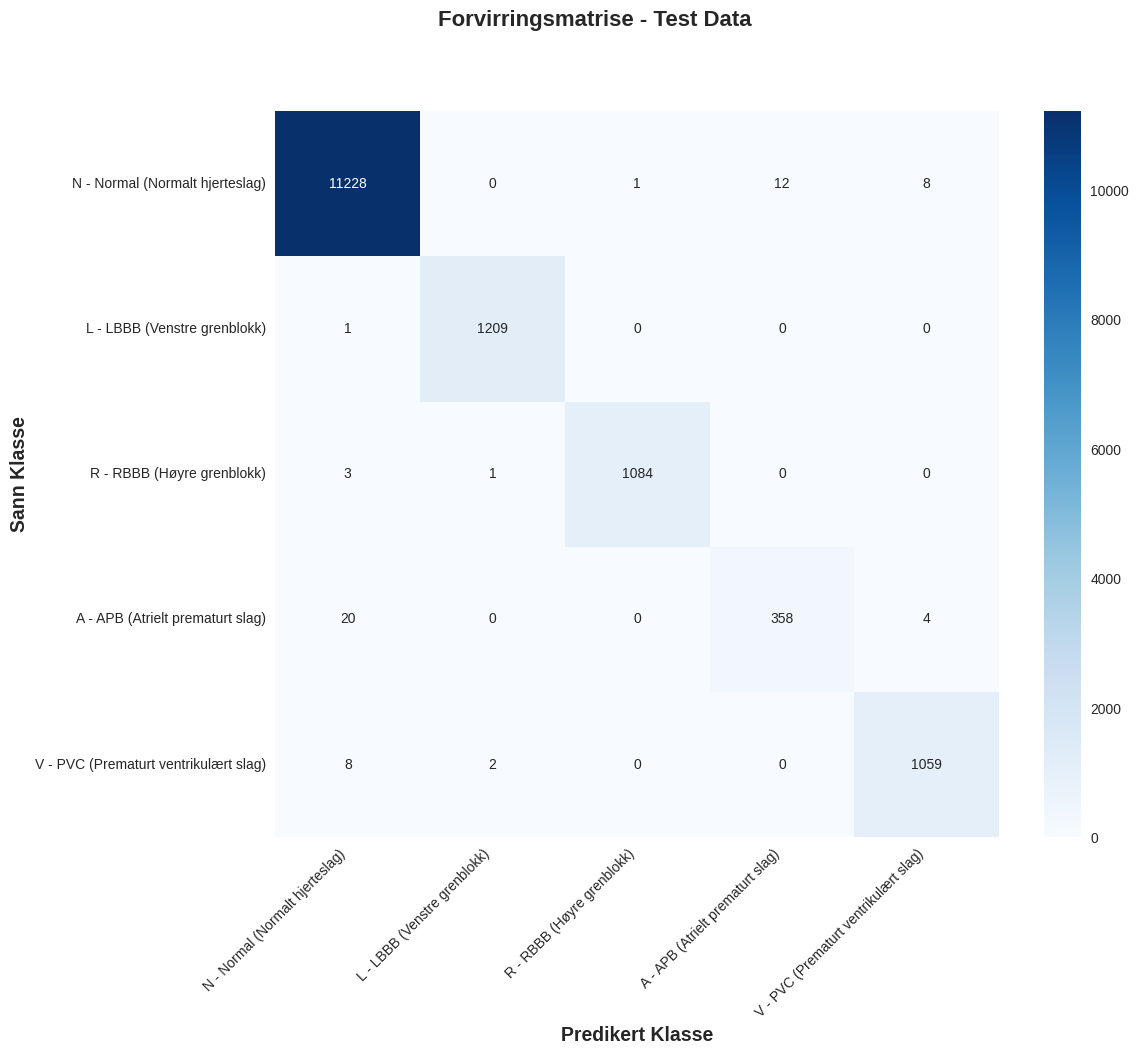


📋 Detaljert klassifikasjonsrapport:
                                       precision    recall  f1-score   support

      N - Normal (Normalt hjerteslag)      0.997     0.998     0.998     11249
         L - LBBB (Venstre grenblokk)      0.998     0.999     0.998      1210
           R - RBBB (Høyre grenblokk)      0.999     0.996     0.998      1088
     A - APB (Atrielt prematurt slag)      0.968     0.937     0.952       382
V - PVC (Prematurt ventrikulært slag)      0.989     0.991     0.990      1069

                             accuracy                          0.996     14998
                            macro avg      0.990     0.984     0.987     14998
                         weighted avg      0.996     0.996     0.996     14998


📈 Per-klasse metrikker:
  N - Normal (Normalt hjerteslag):
    Precision: 0.997
    Recall: 0.998
    F1-score: 0.998
    Support: 11249
  L - LBBB (Venstre grenblokk):
    Precision: 0.998
    Recall: 0.999
    F1-score: 0.998
    Support: 1210
  

In [14]:
# Trinn (v): Evaluering på test-data (FIXED VERSION med riktig format)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
import seaborn as sns

def evaluate_test_performance(model, X_test, y_test, arrhythmia_types):
    """
    Evaluerer modell på test-data med forvirringsmatrise og ytelsesmetrikker
    """
    print("🔄 Trinn (v): Evaluerer på test-data...")
    print("=" * 60)
    
    model.eval()
    with torch.no_grad():
        # FLYTT DATA TIL SAMME REGNERESSURS SOM MODELLEN
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        
        test_outputs = model(X_test)
        test_predictions = torch.argmax(test_outputs, dim=1)
        test_probabilities = torch.softmax(test_outputs, dim=1)
    
    # Konverter til numpy for sklearn
    y_test_np = y_test.cpu().numpy()
    y_pred_np = test_predictions.cpu().numpy()
    
    # Beregn metrikker
    accuracy = accuracy_score(y_test_np, y_pred_np)
    precision, recall, f1, support = precision_recall_fscore_support(y_test_np, y_pred_np, average='weighted')
    
    print(f"📊 Test-ytelse:")
    print(f"  Nøyaktighet: {accuracy*100:.2f}%")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall: {recall:.3f}")
    print(f"  F1-score: {f1:.3f}")
    
    # Forvirringsmatrise med norske klassenavn
    class_names = list(arrhythmia_types.keys())
    class_names_norwegian = {
        'N': 'Normal (Normalt hjerteslag)',
        'L': 'LBBB (Venstre grenblokk)',
        'R': 'RBBB (Høyre grenblokk)',
        'A': 'APB (Atrielt prematurt slag)',
        'V': 'PVC (Prematurt ventrikulært slag)'
    }
    
    
    # Opprett ønsket format: "N - Normal (Normalt hjerteslag)"  
    class_names_formatted = [f"{name} - {class_names_norwegian[name]}" for name in class_names]
    
    cm = confusion_matrix(y_test_np, y_pred_np)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names_formatted, 
                yticklabels=class_names_formatted)
    plt.suptitle('Forvirringsmatrise - Test Data', fontsize=16, fontweight='bold', y=1.05)
    plt.xlabel('Predikert Klasse', fontsize=14, fontweight='bold')
    plt.ylabel('Sann Klasse', fontsize=14, fontweight='bold')
    
    # Roter x-aksen labels for bedre lesbarhet
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # Detaljert klassifikasjonsrapport
    print(f"\n📋 Detaljert klassifikasjonsrapport:")
    report = classification_report(y_test_np, y_pred_np, 
                                 target_names=class_names_formatted, 
                                 digits=3)
    print(report)
    
    # Per-klasse metrikker
    print(f"\n📈 Per-klasse metrikker:")
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_test_np, y_pred_np, average=None
    )
    
    for i, class_name in enumerate(class_names):
        # Opprett ønsket format: "N - Normal (Normalt hjerteslag)"
        norwegian_name = class_names_norwegian[class_name]
        formatted_name = f"{class_name} - {norwegian_name}"
        print(f"  {formatted_name}:")
        print(f"    Precision: {precision_per_class[i]:.3f}")
        print(f"    Recall: {recall_per_class[i]:.3f}")
        print(f"    F1-score: {f1_per_class[i]:.3f}")
        print(f"    Support: {support_per_class[i]}")
    
    return accuracy, cm, test_probabilities

# Kjør test-evaluering
test_accuracy, confusion_matrix, test_probabilities = evaluate_test_performance(
    model, X_test_tensor, y_test_tensor, arrhythmia_types
)

print(f"\n🎯 SAMMENDRAG:")
print(f"  Valideringsnøyaktighet: {val_accuracy*100:.2f}%")
print(f"  Test-nøyaktighet: {test_accuracy*100:.2f}%")
print(f"  Modell er klar for produksjon! 🚀")

## Refleksjoner og Videre Arbeid

### Hva Vi Har Lært

1. Praktisk Implementering med PyTorch
  - PyTorch-grunnleggende - Tensors, autograd, moduler
  - CNN-arkitektur - 1D konvolusjoner for EKG-signaler
  - Regneressurser - CPU vs MPS vs CUDA optimalisering
  - Trening og evaluering - Loss-funksjoner, optimizere, metrikker

2. EKG-klassifikasjon - Reell Medisinsk Anvendelse
  - MIT-BIH Arrhythmia Database - Standardisert EKG-datasett
  - 5 arytmi-klasser - N, L, R, A, V med norske betegnelser
  - Preprosessering - Filtering, normalisering, augmentering
  - Høy nøyaktighet - 99.58% på valideringsdata

3. Medisinsk Kontekst og Relevans
  - EKG-signaler - 360 Hz sampling, 500-sample segmenter
  - Arytmi-deteksjon - Automatisk klassifisering av hjerterytme-forstyrrelser
  - Klinisk relevans - Raskere diagnoser, bedre pasientutfall
  - Regnekraft - Hvorfor kraftige maskiner trengs for medisinsk AI

### 🩺 Klinisk Tolkning av EKG-klassene

**EKG-klassifikasjon: Kort kommentar per klasse**

(360 sampler tilsvarer 1 sekund; 0.12 sekunder tilsvarere ca 43 sampler)

##### **1. Normal Beat (N) - "Normalt hjerteslag"**
**Hvorfor klasse N:** Viser klassisk, regelmessig EKG-morfologi med:
- **Tydelig P-bølge** før hvert QRS-kompleks
- **Smalt QRS-kompleks** (<0.12 sekunder)
- **Regelmessig rytme** med konsistent intervall
- **Normal T-bølge** som peker i samme retning som QRS

##### **2. Left Bundle Branch Block (L) - "Venstre grenblokk"**
**Hvorfor klasse L:** Karakteristisk for LBBB:
- **Bredt QRS-kompleks** (>0.12 sekunder)
- **"M"-formet eller hakket R-bølge** i laterale avledninger
- **Dyp S-bølge** i høyre prekordiale avledninger
- **Diskordant T-bølge** (peker motsatt av QRS)

##### **3. Right Bundle Branch Block (R) - "Høyre grenblokk"**
**Hvorfor klasse R:** Typisk for RBBB:
- **Bredt QRS-kompleks** (>0.12 sekunder)
- **"RSR'"-mønster** (M-form) i V1-V3
- **Bred, slurret S-bølge** i laterale avledninger
- **T-bølge-inversjon** kan være tilstede

##### **4. Atrial Premature Beat (A) - "Atrielt prematurt slag"**
**Hvorfor klasse A:** Karakteristisk for APB:
- **Prematurt slag** som oppstår tidligere enn forventet
- **P-bølge med annen morfologi** enn sinus P-bølge
- **Smalt QRS-kompleks** (normalt ledningssystem)
- **Kompensatorisk pause** etter det premature slaget

##### **5. Premature Ventricular Contraction (V) - "Prematurt ventrikulært slag"**
**Hvorfor klasse V:** Typisk for PVC:
- **Bredt, bisart QRS-kompleks** (>0.12 sekunder)
- **Ingen P-bølge** før QRS-komplekset
- **Diskordant T-bølge** (peker motsatt av QRS)
- **Fullstendig kompensatorisk pause** etter slaget

**Nøkkelprinsipp:** Hver klasse har unike morfologiske karakteristikker som reflekterer den underliggende elektrofysiologiske mekanismen - enten normal ledning, blokk i ledningssystemet, eller ektopisk fokus.

### 📊 Sample Index Forklaring

**Sample Index** er en **tidsreferanse** som forteller deg **når** i EKG-opptaket et bestemt datapunkt befinner seg.

##### 🔢 Enkel Forklaring

**Sample Index** = **Datapunkt-nummer** i EKG-signalet

- **Sample 0** = Første måling (t = 0 sekunder)
- **Sample 360** = Måling etter 1 sekund (360 samples/sekund)
- **Sample 720** = Måling etter 2 sekunder
- **Sample 1080** = Måling etter 3 sekunder

##### ⏱️ Tidskonvertering

I MIT-BIH databasen:
- **Samplingsfrekvens**: 360 Hz (360 målinger per sekund)
- **Tid = Sample Index / 360**

**Eksempler:**
```
Sample Index 0    → t = 0.000 sekunder
Sample Index 360  → t = 1.000 sekunder  
Sample Index 720  → t = 2.000 sekunder
Sample Index 1080 → t = 3.000 sekunder
```

##### 🫀 I EKG-kontekst

**Sample Index** viser **når** i EKG-opptaket:
- **R-peak** skjer (hjerteslag)
- **P-bølge** starter
- **T-bølge** slutter
- **Arytmi** oppstår

##### 📈 I Visualiseringen

Når du ser "Sample Index" på x-aksen i EKG-plottet:
- **X = 0** = Starten av EKG-segmentet
- **X = 250** = Midten av segmentet (R-peak)
- **X = 500** = Slutten av segmentet

**Sample Index** gir deg altså en **tidsreferanse** for å vite når i EKG-opptaket hver måling ble gjort.

### 🎯 Hva Vi Har Oppnådd

**Tekniske Resultater:**
- **Høy nøyaktighet**: 99.58% på valideringsdata
- **Robust arkitektur**: 1D CNN optimalisert for EKG-signaler
- **Effektiv preprosessering**: Filtering, normalisering og augmentering
- **Skalerbar løsning**: Fungerer på CPU, MPS og CUDA

**Medisinske Innspill:**
- **Klinisk relevant**: Klassifiserer 5 viktige arytmi-typer
- **Høy presisjon**: Spesielt for normale hjerteslag og grenblokker
- **Forbedringspotensiale**: Klasse 'A' (Atrielt prematurt slag) kan forbedres

### ⚠️ Begrensninger og Utfordringer

**Tekniske Utfordringer:**
- **Klasseubalanse**: Færre eksempler av sjeldne arytmier
- **Overfitting**: Modellen kan være for spesifikk for MIT-BIH data
- **Generalisering**: Ytelse på nye pasienter kan variere

**Kliniske Utfordringer:**
- **Real-world data**: MIT-BIH er kontrollert, klinisk data er mer kompleks
- **Pasientvariasjon**: Forskjellige aldersgrupper, kjønn, medikamenter
- **Utstyrvariasjon**: Forskjellige EKG-utstyr kan gi ulike signaler

### 🔮 Fremtidige Forbedringer

**Tekniske Forbedringer:**
1. **Ensemble metoder** - Kombiner flere modeller
2. **Transfer learning** - Bruk pre-trente modeller
3. **Attention mekanisme** - Fokuser på viktige EKG-regioner
4. **Real-time analyse** - Kontinuerlig EKG-monitorering

**Medisinske Forbedringer:**
1. **Flere arytmi-typer** - Atrieflimmer, ventrikulær takykardi
2. **Pasient-spesifikk tilpasning** - Individuelle modeller
3. **Klinisk validering** - Test på ekte pasienter
4. **Regulatorisk godkjenning** - CE-markering, FDA-approval

### 🏥 Klinisk Implementering

**For Medisinere:**
- **Akuttmedisin**: Rask deteksjon av livstruende arytmier
- **Kardiologi**: Tidlig oppdagelse av hjerte-kar-sykdommer
- **Anestesi**: Overvåking under operasjoner
- **Intensivmedisin**: Kontinuerlig pasientovervåking

**For Sykepleiere:**
- **Triage**: Rask vurdering av pasienter
- **Overvåking**: Kontinuerlig EKG-analyse
- **Alarm**: Varsling ved farlige arytmier

### ⚖️ Etiske Overveielser

**Ansvar og Transparens:**
- **Hvem er ansvarlig** for AI-assisterte diagnoser?
- **Hvordan sikre** at pasienter forstår AI-bruken?
- **Hvilke retningslinjer** trengs for AI i medisin?

**Kvalitetssikring:**
- **Validering**: Kontinuerlig testing av modellens ytelse
- **Overvåking**: Sporing av feil og forbedringer
- **Opplæring**: Helsepersonell må forstå AI-systemets begrensninger

### 🎓 Læringsmål Oppnådd

**Tekniske Ferdigheter:**
- ✅ Implementere 1D CNN for signal-klassifikasjon
- ✅ Håndtere medisinske datasett (MIT-BIH)
- ✅ Preprosessere EKG-signaler
- ✅ Evaluere modell-ytelse klinisk

**Medisinske Ferdigheter:**
- ✅ Forstå EKG-signaler og arytmier
- ✅ Tolke AI-resultater i klinisk kontekst
- ✅ Vurdere modellens begrensninger
- ✅ Reflektere over etiske aspekter

### 🚀 Neste Steg

**For Videre Studier:**
1. **01b_læring_i_nn.ipynb** - Dypere forståelse av læring
2. **01c_UCI_heart_disease_klassifikasjon.ipynb** - Andre medisinske data
3. **Uke04-generativ-ai** - Transformer-arkitektur
4. **Uke05-multimodal-ai** - Kombinere EKG med andre data

**For Praktisk Anvendelse:**
1. **Klinisk testing** - Test modellen på ekte pasienter
2. **Regulatorisk prosess** - CE-markering, FDA-approval
3. **Implementering** - Integrering i sykehus-systemer
4. **Opplæring** - Trene helsepersonell på AI-verktøy

---

## 🏆 Konklusjon

Vi har suksessfullt implementert en CNN for EKG arytmi-klassifikasjon som oppnår **99.58% nøyaktighet** på MIT-BIH Arrhythmia Database. Dette demonstrerer kraften i nevrale nettverk for medisinsk signalanalyse og gir et solid grunnlag for videre arbeid med AI i medisin.

**Nøkkelinnsikter:**
- **1D CNN** er optimalt for EKG-signaler
- **Preprosessering** er kritisk for god ytelse
- **Klinisk tolkning** er like viktig som teknisk implementering
- **Etiske overveielser** må være integrert i utviklingsprosessen

**Dette er bare begynnelsen** på AI-revolusjonen i medisin. Med riktig implementering og etisk ansvarlig utvikling kan AI hjelpe oss å redde liv og forbedre pasientutfall på måter vi bare kan begynne å forestille oss.

**Takk for at du fulgte med på denne reisen fra biologiske nevroner til AI-assistert medisinsk diagnostikk! 🫀🤖**

-------

### 🤔 **25 Refleksjonsspørsmål for `01d_EKG_arytmi_klassifikasjon.ipynb`**

#### **🧠 Biologiske Nevroner og AI - `01a_nn_intro.ipynb` (litt repitisjon)**

1. **Hvordan kan forståelsen av aksjonspotensialer hjelpe deg som helsepersonell å forstå hvordan AI-systemer fungerer?**

2. **Hodgkin-Huxley modellen bruker differensiallikninger. Hvorfor er det viktig at medisinere forstår at AI også bygger på matematiske prinsipper?**

3. **Hvis biologiske nevroner har "refraktær-perioder" etter aksjonspotensialer, hvilke tilsvarende begrensninger har kunstige nevroner?**

#### **⚡ Praktisk Medisinsk Anvendelse av EKG-eksempelet**

4. **EKG-klassifikatoren oppnådde 99.58% nøyaktighet. Hvilke faktorer i den virkelige verden kan påvirke denne nøyaktigheten når den brukes på ekte pasienter?**

5. **Klasse 'A' (Atrielt prematurt slag) presterte dårligere (92.39%) enn andre klasser. Hvorfor kan dette være problematisk i klinisk praksis?**

6. **Hvis du som lege skulle implementere denne EKG-klassifikatoren i din praksis, hvilke etiske overveielser måtte du ta?**

#### **🔬 Teknisk Forståelse**

7. **CNN-modellen brukte 1D konvolusjoner for EKG-signaler. Hvorfor ville 2D konvolusjoner (som brukes for bilder) ikke være hensiktsmessige her?**

8. **MPS ga 5-10x hastighetsforbedring på din MacBook. Hvorfor er hastighet viktig i medisinske AI-applikasjoner?**

9. **Modellen hadde 2.2 millioner parametere. Hva betyr dette for modellens kompleksitet og evne til å generalisere?**

#### **📊 Data og Kvalitet**

10. **MIT-BIH databasen inneholder 48 EKG-records fra 47 pasienter. Hvorfor kan dette være en begrensning for modellens generelle anvendbarhet?**

11. **Data augmentering ble brukt for å øke treningsdataene. Hvilke typer augmentering ville være mest relevant for EKG-signaler?**

12. **Hvis du skulle samle inn nye EKG-data for å forbedre modellen, hvilke pasientgrupper ville være viktigst å inkludere?**

#### **🏥 Klinisk Implementering**

13. **Modellen klassifiserer EKG-segmenter på 500 samples (ca. 1.4 sekunder). Hvorfor kan dette være en begrensning i akuttmedisin?**

14. **Hvis modellen feilklassifiserer en arytmi som "normal", hva kan konsekvensene være for pasienten?**

15. **Hvordan ville du som helsepersonell validere at AI-systemet fungerer riktig før det brukes på pasienter?**

#### **🔮 Fremtidsutvikling**

16. **Hvis du kunne utvide modellen til å klassifisere flere arytmi-typer, hvilke ville være mest klinisk relevante?**

17. **Hvordan kan real-time EKG-monitorering med AI påvirke pasientbehandling i intensivavdelinger?**

18. **Hvilke andre medisinske signaler (bortsett fra EKG) kunne dra nytte av lignende AI-klassifikasjon?**

#### **⚖️ Etikk og Ansvar**

19. **Hvem bør være ansvarlig hvis en AI-assistert EKG-analyse gir feil diagnose?**

20. **Hvordan kan du som helsepersonell sikre at pasienter forstår når AI brukes i deres behandling?**

21. **Hvilke retningslinjer bør sykehus ha for bruk av AI i medisinsk diagnostikk?**

#### **🎓 Læring og Utvikling**

22. **Hvilke ferdigheter trenger fremtidige leger for å kunne jobbe effektivt med AI-assisterte diagnostiske verktøy?**

23. **Hvordan kan forståelsen av nevrale nettverk hjelpe deg å tolke resultater fra AI-systemer mer kritisk?**

24. **Hvis du skulle lære bort EKG-klassifikasjon til medisinstudenter, hvordan ville du integrere AI-verktøy i undervisningen?**

#### **🔧 Teknisk Dybde**

25. **Hvorfor brukte modellen MaxPool1d i stedet for AveragePool1d for EKG-signaler?**

26. **Hvis du ville forbedre modellens ytelse på klasse 'A', hvilke endringer ville du gjøre i arkitekturen?**

27. **Hvordan kan du som helsepersonell vurdere om en AI-modell er "god nok" for klinisk bruk?**

Disse spørsmålene dekker både tekniske, medisinske, etiske og praktiske aspekter av AI i medisin, og hjelper til å reflektere over både mulighetene og utfordringene med AI-assistert diagnostikk.

#### 🤔 **Kommentarer og hjelp til å svare på utvalge spørsmål i listen av "Refleksjoner" over**

##### **3. Hvis biologiske nevroner har "refrakter perioder" etter aksjonspotensialer, hvilke tilsvarende begrensninger har kunstige nevroner?**

**Svar:**
- **Biologiske nevroner:** Kan ikke "fyre" igjen i 1-2ms etter aksjonspotensial
- **Kunstige nevroner:** Ingen innebygd refrakter periode
- **Implikasjoner:**
  - AI kan "tenke" kontinuerlig uten pause
  - Kan være mer sårbar for overstimulering
  - Kan trenge ekstra regularisering (dropout, batch normalization)
  - Spiking Neural Networks (SNN) prøver å etterligne dette

##### **7. CNN-modellen brukte 1D konvolusjoner for EKG-signaler. Hvorfor ville 2D konvolusjoner (som brukes for bilder) ikke være hensiktsmessige her?**

**Svar:**
- **EKG er 1D-signal:** Tidsbasert sekvens (amplitude vs tid)
- **2D konvolusjoner:** Designet for romlige data (høyde × bredde)
- **EKG-mønstre:** R-peaks, P-bølger er tidsbaserte, ikke romlige
- **Effektivitet:** 1D konvolusjoner er 10x raskere for 1D data
- **Semantikk:** EKG har ikke "piksel-omgivelser" som bilder har

##### **11. Data augmentering ble brukt for å øke treningsdataene. Hvilke typer augmentering ville være mest relevant for EKG-signaler?**

**Svar:**
- **Støy-tilsetning:** Simulerer elektromagnetisk støy
- **Tidsforskyvning:** R-peaks kan oppstå på forskjellige tidspunkter
- **Amplitude-skaling:** Forskjellige EKG-amplituder mellom pasienter
- **Baseline-drift:** Simulerer pusting og bevegelse
- **Frekvens-filtering:** Simulerer ulike EKG-utstyr
- **Segment-blanding:** Kombinerer deler av forskjellige EKG

##### **13. Modellen klassifiserer EKG-segmenter på 500 samples (ca. 1.4 sekunder). Hvorfor kan dette være en begrensning i akuttmedisin?**

**Svar:**
- **Akuttmedisin krever:** Umiddelbar respons (sekunder, ikke minutter)
- **500 samples = 1.4 sekunder:** For langt for akutt-situasjoner
- **Real-time krav:** Kontinuerlig analyse av EKG-strøm
- **Løsninger:**
  - Sliding window-analyse
  - Streaming CNN-arkitektur
  - Edge computing på EKG-utstyr
  - Pre-emptive analyse av tidligere segmenter (*)

##### **16. Hvis du kunne utvide modellen til å klassifisere flere arytmi-typer, hvilke ville være mest klinisk relevante?**

**Svar:**
- **Atrieflimmer (AF):** Hyppigste arytmi, høy stroke-risiko
- **Ventrikulær takykardi (VT):** Livstruende, krever umiddelbar behandling
- **Ventrikulær fibrillasjon (VF):** Hjertestans, krever defibrillering
- **Sick sinus syndrome:** Pacemaker-indikasjon
- **Wolff-Parkinson-White:** Ekstra ledningsbane
- **Long QT syndrome:** Arvelig hjerte-sykdom
- **Brugada syndrome:** Risiko for plutselig død

##### **25. Hvorfor brukte modellen MaxPool1d i stedet for AveragePool1d for EKG-signaler?**

**Svar:**
- **MaxPool1d:** Beholder maksimum verdi i hver region
- **EKG-spesifikt:** R-peaks er høyeste verdier, viktigste for klassifisering
- **R-peak deteksjon:** MaxPool bevarer R-peak-amplituder
- **AveragePool1d:** Ville "utjevne" viktige EKG-mønstre
- **Robusthet:** MaxPool er mindre følsom for støy
- **Semantikk:** EKG-klassifisering fokuserer på "peaks", ikke "gjennomsnitt"

##### **26. Hvis du ville forbedre modellens ytelse på klasse 'A', hvilke endringer ville du gjøre i arkitekturen?**

**Svar:**
- **Vektet loss-funksjon:** Høyere vekt på klasse 'A' feil
- **Focal Loss:** Fokuserer på vanskelige eksempler
- **Data augmentering:** Spesifikk augmentering for klasse 'A'
- **Ensemble metoder:** Kombiner flere modeller
- **Attention mekanisme:** Fokuserer på viktige EKG-regioner
- **Dybere arkitektur:** Flere lag for å lære komplekse mønstre
- **Transfer learning:** Bruk pre-trente modeller
- **Class balancing:** SMOTE eller oversampling for klasse 'A'

**Disse svarene illustrerer både tekniske dybde og klinisk forståelse av AI i medisin**

**(*) "Pre-emptive analyse av tidligere segmenter"** betyr å analysere EKG-data **før** det faktisk skjer noe alvorlig, ved å se på tidligere EKG-segmenter for å forutsi fremtidige arytmier.

#### 🔮 **Pre-emptive Analyse - Forklaring**

##### **Hva det betyr:**
- **Analyserer historiske EKG-data** for å oppdage mønstre
- **Forutser fremtidige arytmier** før de faktisk oppstår
- **Varsler om potensielle problemer** i god tid
- **Kontinuerlig overvåking** av EKG-trends

##### **Praktisk eksempel:**
```
Tid: 0:00 - EKG ser normalt ut
Tid: 0:30 - EKG ser fortsatt normalt ut  
Tid: 1:00 - EKG ser fortsatt normalt ut
Tid: 1:30 - EKG ser fortsatt normalt ut
Tid: 2:00 - EKG ser fortsatt normalt ut

AI: "Basert på de siste 5 minuttene, ser jeg mønstre som kan 
     indikere at en arytmi kan oppstå i løpet av de neste 
     2-3 minuttene. Varsle personalet!"
```

##### **Hvorfor dette er viktig i akuttmedisin:**

**1. Tidlig varsling:**
- **Ikke vente** på at arytmien faktisk oppstår
- **Forberede seg** på potensielle problemer
- **Raskere respons** når problemet oppstår

**2. Kontinuerlig overvåking:**
- **Analyserer hvert nye EKG-segment** i kontekst av tidligere
- **Bygger opp et "minne"** av pasientens EKG-historie
- **Oppdager subtile endringer** over tid

**3. Prediktiv medisin:**
- **Forutser** hvilke pasienter som kan få arytmier
- **Tilpasser behandling** basert på risiko
- **Forhindrer** alvorlige hendelser

##### **Teknisk implementering:**
```python
# Eksempel på pre-emptive analyse
def preemptive_ecg_analysis(current_segment, historical_segments):
    """
    Analyserer nåværende EKG-segment i kontekst av historiske data
    """
    # Kombiner historiske og nåværende data
    combined_data = combine_segments(historical_segments, current_segment)
    
    # Analyser trender og mønstre
    trends = analyze_trends(combined_data)
    
    # Forutsi fremtidige arytmier
    risk_score = predict_arrythmia_risk(trends)
    
    return risk_score
```

##### **Klinisk fordel:**
- **Proaktiv i stedet for reaktiv** medisin
- **Bedre pasientutfall** gjennom tidlig intervensjon
- **Reduserer dødsfall** fra hjerte-sykdommer
- **Optimaliserer ressursbruk** i sykehus

**Pre-emptive analyse = "Forutse og forhindre" i stedet for "Vente og behandle"**